In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [0]:
!pip install steamreviews
import steamreviews

import pandas as pd
import numpy as np 
from bs4 import BeautifulSoup
import requests
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry
import json
import urllib.request as request
import re
import datetime
import time 
# NLP
import multiprocessing as mp
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer
from nltk.probability import FreqDist
# Topic Modeling
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
# Sentiment Analysis
from textblob import TextBlob

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Get Information on GameApp level

### Get the list of all the GameApps

In [0]:
# http://api.steampowered.com/ISteamApps/GetAppList/v0001/?key=STEAMKEY&format=json
with open('AppListV1.json', 'r') as f:
    apps = json.load(f)
    
AppList = apps['applist']['apps']['app']
len(AppList)

94290

### Get the information of all the GameApps

In [0]:
def retrySession(
    retries=5,
    backoff_factor=0.3,
    status_forcelist=(500, 502, 504),
    session=None):
    session = session or requests.Session()
    retry = Retry(
        total=retries,
        read=retries,
        connect=retries,
        backoff_factor=backoff_factor,
        status_forcelist=status_forcelist,
    )
    adapter = HTTPAdapter(max_retries=retry)
    session.mount('http://', adapter)
    session.mount('https://', adapter)
    return session

In [0]:
def webCapture(url):
    headers = {
   # pretend I am a browser
   'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/76.0.3809.87 Safari/537.36',
   }
    s = requests.Session()
    response = retrySession(session=s).get(url, headers = headers, verify=False)
    soup = BeautifulSoup(response.text, 'html.parser') #parse the data
    return soup

In [0]:
AppID = []
AppName = []
Genre = []
Tags = []
Developer = []
Publisher = []
ReviewInfor = []
ReviewStatus = []
ReleaseDate = []
IsFree = []
Price = []
count = 0

#for i in range(0, len(AppList)):
for i in range(82242, 90000):
    ID = str(AppList[i]["appid"])
    Name = str(AppList[i]["name"])
    url = f"https://store.steampowered.com/app/{ID}/{Name}"
    # scrapy web page
    gameDetails = webCapture(url)
    
    # get game tags
    try: 
        tag_infor = gameDetails.select("div.glance_tags.popular_tags")[0].get_text()
        tags = re.sub(r'[\t\n\r+]', ' ', tag_infor)
        tags = list(' '.join(tags.split()).split(" "))   # remove white space and put tags in a list
        genre = tags[0] # the first tag is the main genre for the game

    # get developer and publisher
        developer = re.sub(r"[\n]", '', 
                       gameDetails.select("div.dev_row > div.summary.column")[0].get_text().strip())
    
        publisher = re.sub(r"[\n]", '', 
                       gameDetails.select("div.dev_row > div.summary.column")[1].get_text().strip())

    # get "All Reviews" information 
        review_infor = re.sub(r'[\t\n\r+]', '', 
               gameDetails.select('div.user_reviews_summary_row > div.summary.column')[0].get_text())
        review_status = True if review_infor != "No user reviews" else False
        
    # get release date
        date = gameDetails.select("div.release_date > div.date")[0].get_text()
    
    except: 
        genre = None
        tags = None
        developer = None
        publisher = None
        review_infor = None
        review_status = None
        date = None
    
    # get app price
    game_link = f"http://store.steampowered.com/api/appdetails?appids={ID}"
    s = requests.Session()
    source = retrySession(session=s).get(game_link, headers={'User-Agent':'Mozilla/5.0'}, verify=False)
    json_dict = json.loads(source.text)
    
    try: 
        if json_dict[ID]["success"] == True: 
            is_free = json_dict[ID]["data"]["is_free"]
            try: 
                price = json_dict[ID]["data"]["price_overview"] if is_free == False else None
            except: 
                price = None
        else: 
            is_free = None
            price = None
    except TypeError: 
        continue
    
    AppID.append(ID)
    AppName.append(Name)
    Genre.append(genre)
    Tags.append(tags)
    Developer.append(developer)
    Publisher.append(publisher)
    ReviewInfor.append(review_infor)
    ReviewStatus.append(review_status)
    ReleaseDate.append(date)
    IsFree.append(is_free)
    Price.append(price)
    count += 1

print(count)

In [0]:
df_games = pd.DataFrame(list(zip(AppID, AppName, Genre, Tags, Developer, Publisher, ReviewInfor,
                                         ReviewStatus, ReleaseDate, IsFree, Price)),
                       columns=["AppID", "AppName", "Genre", "Tags", "Developer", "Publisher", "ReviewInfor",
                                         "ReviewStatus", "ReleaseDate", "IsFree", "Price"])
df_games.head(3)

,AppID,AppName,Genre,Tags,Developer,Publisher,ReviewInfor,ReviewStatus,ReleaseDate,IsFree,Price
0,5702,BLUR Trailer 3,None,None,None,None,None,None,None,None,None
1,5703,StargateResistance,None,None,None,None,None,None,None,False,None
2,5706,Guns Of Icarus 1,None,None,None,None,None,None,None,False,None


In [0]:
df_games.to_csv("steam_games.csv",index=False)

### Get data of GameApps of interest

#### Clean Data and create new columns

In [0]:
steam = pd.read_csv("steam_games.csv")

In [0]:
# extract the review summary info and reviewNum from 'ReviewInfor' column
steam['ReviewSum'] = steam['ReviewInfor'].str.extract(r'(^[^\-]+)-[.]*')
steam['ReviewNum'] = steam['ReviewSum'].str.extract(r'^[^\(]+\(([\d]*)\)')
steam['ReviewSum'] = steam['ReviewSum'].str.extract(r'(^[^\(]+)\([.]*')

In [0]:
steam_2 = steam.copy()

In [0]:
# filter the games that can be reviewed and are not free
steam_2 = steam_2.loc[(steam_2["ReviewStatus"] == True) & (steam_2["IsFree"] == False),]

In [0]:
# filter out the games that need more reviews or with no reviews
steam_3 = steam_2[steam_2['ReviewSum'].isna() == False]

In [0]:
# filter the games that were released before 2020.

# check what are the formats here except for mmm dd, yyyy
steam_3['format_flag'] = steam_3['ReleaseDate'].str.match('[a-zA-Z]{3} [0-9]+, [0-9]{4}')
#steam_3[steam_3['format_flag'] == False]

# clean mmm-yy to mmm yyyy
steam_3['ReleaseDate'] = steam_3['ReleaseDate'].str.replace(r'([a-zA-Z]{3})-([0-9]{2})',r'\1 20\2')
# format mmm yyyy and mmm dd, yyyy to yyyy-mm-dd
steam_3['RD_Cleaned'] = pd.to_datetime(steam_3['ReleaseDate']).dt.date
steam_3['ReleaseYear'] = pd.to_datetime(steam_3['RD_Cleaned']).dt.year

# filter the games that were released between 2010 and 2020.
steam_4 = steam_3.loc[(steam_3["ReleaseYear"] < 2020) & (steam_3["ReleaseYear"] >= 2010),]

/Users/rayna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/rayna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/rayna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

,AppID,AppName,Genre,Tags,Developer,Publisher,ReviewInfor,ReviewStatus,ReleaseDate,IsFree,Price,ReviewSum,ReviewNum,format_flag,RD_Cleaned,ReleaseYear
0,926170,Achromatic,Indie,"['Indie', 'Puzzle']",Studio Goya,Studio Goya,Positive(13)- 92% of the 13 user reviews for t...,True,"Sep 28, 2018",False,"{'currency': 'USD', 'initial': 499, 'final': 4...",Positive,13,True,2018-09-28,2018
1,926180,Bubsy: Paws on Fire!,Action,"['Action', 'Adventure', 'Runner', 'Indie', 'Ps...",Choice Provisions,Accolade,Mostly Positive(28)- 71% of the 28 user review...,True,"May 16, 2019",False,"{'currency': 'USD', 'initial': 2499, 'final': ...",Mostly Positive,28,True,2019-05-16,2019
8,926390,Infected Shelter,Action,"['Action', 'Roguelike', 'Indie', 'Action', 'Ad...",Dark Blue Games,Dark Blue Games,Very Positive(21)- 85% of the 21 user reviews ...,True,"Nov 11, 2019",False,"{'currency': 'USD', 'initial': 999, 'final': 9...",Very Positive,21,True,2019-11-11,2019
14,926470,Kolkhoz: The Red Wedge,Adventure,"['Adventure', 'Indie', 'Story', 'Rich', '2D', ...",Deniz Kayacan,Deniz Kayacan,Positive(11)- 81% of the 11 user reviews for t...,True,"Oct 19, 2018",False,"{'currency': 'USD', 'initial': 999, 'final': 9...",Positive,11,True,2018-10-19,2018
23,926650,Order of Battle: Endsieg,Strategy,"['Strategy', 'Simulation', 'Free', 'to', 'Play']",The Artistocrats,Slitherine Ltd.,Mostly Positive(18)- 72% of the 18 user review...,True,"Nov 13, 2018",False,"{'currency': 'USD', 'initial': 1499, 'final': ...",Mostly Positive,18,True,2018-11-13,2018


In [0]:
def clean_genres(data):
    genres = data.copy()
    # genre cleaning
    genres.loc[data['Genre'] == 'Massively', 'Genre'] = 'Multiplayer'

    genres.loc[data['Genre'] == 'RPGMaker', 'Genre'] = 'RPG'

    genres.loc[data['Genre'] == 'Zombies', 'Genre'] = 'Battle'
    genres.loc[data['Genre'] == 'Survival', 'Genre'] = 'Battle'
    genres.loc[data['Genre'] == 'PvP', 'Genre'] = 'Battle'
    genres.loc[data['Genre'] == 'Violent', 'Genre'] = 'Battle'

    genres.loc[data['Genre'] == 'Bullet', 'Genre'] = 'Shoot'

    genres.loc[data['Genre'] == 'Soccer', 'Genre'] = 'Sports'
    genres.loc[data['Genre'] == 'Swordplay', 'Genre'] = 'Sports'
    genres.loc[data['Genre'] == 'Football', 'Genre'] = 'Sports'
    genres.loc[data['Genre'] == 'Tennis', 'Genre'] = 'Sports'
    genres.loc[data['Genre'] == 'Motorbike', 'Genre'] = 'Sports'
    genres.loc[data['Genre'] == 'Baseball', 'Genre'] = 'Sports'
    genres.loc[data['Genre'] == 'Basketball', 'Genre'] = 'Sports'
    genres.loc[data['Genre'] == 'Golf', 'Genre'] = 'Sports'
    genres.loc[data['Genre'] == 'Boxing', 'Genre'] = 'Sports'
    genres.loc[data['Genre'] == 'Fishing', 'Genre'] = 'Sports'
    genres.loc[data['Genre'] == 'Bikes', 'Genre'] = 'Sports'

    genres.loc[data['Genre'] == 'Action', 'Genre'] = 'Action-Adventure'
    genres.loc[data['Genre'] == 'Adventure', 'Genre'] = 'Action-Adventure'
    return genres

def filter_top_genres(data):
    top_genres_list = ['Multiplayer', 'RPG', 'Battle', 'Shoot', 'Sports', 'Action-Adventure', \
              'Sandbox', 'Simulation', 'Fighting', 'Racing']
    # filter the top 10 genres
    top_genres = data.loc[data['Genre'].isin(top_genres_list) == True,]
    return top_genres

#### Choose our new data

In [0]:
steam_genres = clean_genres(steam_4)
top_genres = filter_top_genres(steam_genres)

In [0]:
# Get Madhouse/Shueisha
MS_games = steam_genres.loc[(steam_genres['Developer'] == 'Madhouse/Shueisha'),]
MS_games['Genre'].value_counts()

Action-Adventure    103
Name: Genre, dtype: int64

In [0]:
MS_games.to_csv("MS_games.csv")

## Get the reviews of sample GameApps

### Define functions to get reviews
**get_reviews, get_reviews_json, read_reviews_json_to_df**

In [0]:
def get_reviews_json(ids_list):
    # download reviews for each id and return json files
    # Reference: https://partner.steamgames.com/doc/store/getreviews
    request_params = dict()
    request_params['language'] = 'english'
    reviews = steamreviews.download_reviews_for_app_id_batch(ids_list, chosen_request_params=request_params)

In [0]:
def read_reviews_json_to_df(ids_list):
    # Check what are the info there
    # review_dict["reviews"][list(review_dict["reviews"])[0]]
    # define variables
    GameID = []
    SteamID = []
    ReviewID = []
    NumGamesOwned = []
    NumReviewsGiven = []
    PlayTime = []
    PlayTimeLastTwoWeeks = []
    LastPlayTime = []
    Language = []
    Review = []
    TimeCreated = []
    VoteUp = []
    VoteFunny = []
    CommentCount = []
    SteamPurchase = []
    WriteEarly = []

    ids = ids_list
    # read json files and get info
    for i in range(len(ids)):
        gameid = ids[i]
        with open(f'data/review_{gameid}.json', 'r') as f:
            review_dict = json.load(f)

        if len(review_dict["reviews"]) != 0:
            for j in range(len(review_dict["reviews"])):
                try: 
                    reviewids = list(review_dict["reviews"])
                    doc = review_dict["reviews"][reviewids[j]]
                    author_profile = doc["author"]
                    language = doc["language"]
                    review = doc["review"]
                    timestamp_created = datetime.datetime.fromtimestamp(doc["timestamp_created"])
                    if doc["voted_up"] == True:
                        votes_up = doc["votes_up"]

                    else:
                        votes_up = None
                    votes_funny = doc["votes_funny"]
                    comment_count = doc["comment_count"]
                    steam_purchase = doc["steam_purchase"]
                    write_early = doc["written_during_early_access"]
                    #author
                    steamid = author_profile["steamid"]
                    num_games_owned = author_profile["num_games_owned"]
                    num_reviews = author_profile["num_reviews"]
                    playtime_forever = author_profile["playtime_forever"]
                    playtime_last_two_weeks = author_profile["playtime_last_two_weeks"]
                    last_played = datetime.datetime.fromtimestamp(author_profile["last_played"])
                except TypeError: 
                    continue

                GameID.append(gameid)
                ReviewID.append(reviewids[j])
                SteamID.append(steamid)
                NumGamesOwned.append(num_games_owned)
                NumReviewsGiven.append(num_reviews)
                PlayTime.append(playtime_forever)
                PlayTimeLastTwoWeeks.append(playtime_last_two_weeks)
                LastPlayTime.append(last_played)
                Language.append(language)
                Review.append(review)
                TimeCreated.append(timestamp_created)
                VoteUp.append(votes_up)
                VoteFunny.append(votes_funny)
                CommentCount.append(comment_count)
                SteamPurchase.append(steam_purchase)
                WriteEarly.append(write_early)
    
    # store all info to a dataframe
    reviews = pd.DataFrame(list(zip(GameID, SteamID, ReviewID, NumGamesOwned, NumReviewsGiven, PlayTime, 
                PlayTimeLastTwoWeeks, LastPlayTime, Language, Review, TimeCreated, VoteUp, VoteFunny, 
                CommentCount, SteamPurchase, WriteEarly)),
                columns=["GameID", "SteamID", "ReviewID", "NumGamesOwned", "NumReviewsGiven", "PlayTime", 
                         "PlayTimeLastTwoWeeks","LastPlayTime", "Language", "Review", "TimeCreated", 
                         "VoteUp", "VoteFunny", "CommentCount", "SteamPurchase", "WriteEarly"])
                          
    return reviews;

In [0]:
def get_reviews(ids_list):
    get_reviews_json(ids_list)
    reviews = read_reviews_json_to_df(ids_list)
    return reviews

### Get reviews

In [0]:
# get a sample of appids of mosetly negative & very positive DG simulation games
dg_games = pd.read_csv("DG_games.csv")
sample_ids = dg_games['AppID'].to_list()
len(sample_ids)

260

In [0]:
# there are totaly 9920 reviews for these 260 DG simulation games.
dg_reviews = read_reviews_json_to_df(sample_ids)
dg_reviews['SteamID'].count()

9920

In [0]:
# Whole Second Part
data = pd.read_csv('gameids.txt', header=None)
gameids = data[0].to_list()
len(gameids)

3904

In [0]:
# 1047657 reviews for 3904 games
reviews_p2 = get_reviews_json(gameids)
reviews_p2 = read_reviews_json_to_df(gameids)
reviews_p2['SteamID'].count()

Loading idprocessed_on_20200527.txt
Creating idprocessed_on_20200527.txt
[appID = 234190] expected #reviews = 3080
[appID = 234190] num_reviews = 3080 (expected: 3080)
[appID = 234270] expected #reviews = 978
[appID = 234270] num_reviews = 978 (expected: 978)
[appID = 234370] expected #reviews = 70
[appID = 234370] num_reviews = 70 (expected: 70)
[appID = 234390] expected #reviews = 1800
[appID = 234390] num_reviews = 1800 (expected: 1800)
[appID = 232950] expected #reviews = 418
[appID = 232950] num_reviews = 418 (expected: 418)
[appID = 233310] expected #reviews = 118
[appID = 233310] num_reviews = 118 (expected: 118)
[appID = 233350] expected #reviews = 337
[appID = 233350] num_reviews = 337 (expected: 337)
[appID = 605990] expected #reviews = 74
[appID = 605990] num_reviews = 74 (expected: 74)
[appID = 606000] expected #reviews = 32
[appID = 606000] num_reviews = 32 (expected: 32)
[appID = 605310] expected #reviews = 29
[appID = 605310] num_reviews = 29 (expected: 29)
[appID = 6051

[appID = 595080] expected #reviews = 19
[appID = 595080] num_reviews = 19 (expected: 19)
[appID = 595090] expected #reviews = 62
[appID = 595090] num_reviews = 62 (expected: 62)
[appID = 595100] expected #reviews = 45
[appID = 595100] num_reviews = 45 (expected: 45)
[appID = 594040] expected #reviews = 81
[appID = 594040] num_reviews = 81 (expected: 81)
[appID = 594050] expected #reviews = 69
[appID = 594050] num_reviews = 69 (expected: 69)
[appID = 594200] expected #reviews = 12
[appID = 594200] num_reviews = 12 (expected: 12)
[appID = 594320] expected #reviews = 21
[appID = 594320] num_reviews = 21 (expected: 21)
[appID = 594350] expected #reviews = 53
[appID = 594350] num_reviews = 53 (expected: 53)
[appID = 593850] expected #reviews = 30
[appID = 593850] num_reviews = 30 (expected: 30)
[appID = 593530] expected #reviews = 58
[appID = 593530] num_reviews = 58 (expected: 58)
[appID = 593560] expected #reviews = 20
[appID = 593560] num_reviews = 20 (expected: 20)
[appID = 593740] expe

[appID = 584890] expected #reviews = 104
[appID = 584890] num_reviews = 104 (expected: 104)
[appID = 584990] expected #reviews = 139
[appID = 584990] num_reviews = 139 (expected: 139)
[appID = 584370] expected #reviews = 59
[appID = 584370] num_reviews = 59 (expected: 59)
[appID = 584097] expected #reviews = 66
[appID = 584097] num_reviews = 66 (expected: 66)
[appID = 583730] expected #reviews = 12
[appID = 583730] num_reviews = 12 (expected: 12)
[appID = 582980] expected #reviews = 15
[appID = 582980] num_reviews = 15 (expected: 15)
[appID = 582990] expected #reviews = 19
[appID = 582990] num_reviews = 19 (expected: 19)
[appID = 583040] expected #reviews = 61
[appID = 583040] num_reviews = 61 (expected: 61)
[appID = 583060] expected #reviews = 11
[appID = 583060] num_reviews = 11 (expected: 11)
[appID = 583140] expected #reviews = 24
[appID = 583140] num_reviews = 24 (expected: 24)
[appID = 582540] expected #reviews = 17
[appID = 582540] num_reviews = 17 (expected: 17)
[appID = 582560

[appID = 574890] expected #reviews = 22
[appID = 574890] num_reviews = 22 (expected: 22)
[appID = 574940] expected #reviews = 83
[appID = 574940] num_reviews = 83 (expected: 83)
[appID = 574580] expected #reviews = 26
[appID = 574580] num_reviews = 26 (expected: 26)
[appID = 574080] expected #reviews = 275
[appID = 574080] num_reviews = 275 (expected: 275)
[appID = 574090] expected #reviews = 834
[appID = 574090] num_reviews = 834 (expected: 834)
[appID = 574120] expected #reviews = 27
[appID = 574120] num_reviews = 27 (expected: 27)
[appID = 574310] expected #reviews = 153
[appID = 574310] num_reviews = 153 (expected: 153)
[appID = 573110] expected #reviews = 23
[appID = 573110] num_reviews = 23 (expected: 23)
[appID = 573120] expected #reviews = 501
[appID = 573120] num_reviews = 501 (expected: 501)
[appID = 573270] expected #reviews = 24
[appID = 573270] num_reviews = 24 (expected: 24)
[appID = 573290] expected #reviews = 14
[appID = 573290] num_reviews = 14 (expected: 14)
[appID = 

[appID = 564040] expected #reviews = 16
[appID = 564040] num_reviews = 16 (expected: 16)
[appID = 563550] expected #reviews = 47
[appID = 563550] num_reviews = 47 (expected: 47)
[appID = 563680] expected #reviews = 9
[appID = 563680] num_reviews = 9 (expected: 9)
[appID = 563260] expected #reviews = 23
[appID = 563260] num_reviews = 23 (expected: 23)
[appID = 562399] expected #reviews = 35
[appID = 562399] num_reviews = 35 (expected: 35)
[appID = 562700] expected #reviews = 36
[appID = 562700] num_reviews = 36 (expected: 36)
[appID = 562330] expected #reviews = 26
[appID = 562330] num_reviews = 26 (expected: 26)
[appID = 562372] expected #reviews = 7
[appID = 562372] num_reviews = 7 (expected: 7)
[appID = 562373] expected #reviews = 38
[appID = 562373] num_reviews = 38 (expected: 38)
[appID = 562379] expected #reviews = 13
[appID = 562379] num_reviews = 13 (expected: 13)
[appID = 562382] expected #reviews = 10
[appID = 562382] num_reviews = 10 (expected: 10)
[appID = 562386] expected #

[appID = 554680] expected #reviews = 10
[appID = 554680] num_reviews = 10 (expected: 10)
[appID = 554700] expected #reviews = 8
[appID = 554700] num_reviews = 8 (expected: 8)
[appID = 554810] expected #reviews = 63
[appID = 554810] num_reviews = 63 (expected: 63)
[appID = 554180] expected #reviews = 30
[appID = 554180] num_reviews = 30 (expected: 30)
[appID = 554280] expected #reviews = 32
[appID = 554280] num_reviews = 32 (expected: 32)
[appID = 554390] expected #reviews = 16
[appID = 554390] num_reviews = 16 (expected: 16)
[appID = 554470] expected #reviews = 22
[appID = 554470] num_reviews = 22 (expected: 22)
[appID = 553950] expected #reviews = 46
[appID = 553950] num_reviews = 46 (expected: 46)
[appID = 553800] expected #reviews = 28
[appID = 553800] num_reviews = 28 (expected: 28)
[appID = 553820] expected #reviews = 21
[appID = 553820] num_reviews = 21 (expected: 21)
[appID = 552880] expected #reviews = 142
[appID = 552880] num_reviews = 142 (expected: 142)
[appID = 552970] expe

[appID = 543191] expected #reviews = 8
[appID = 543191] num_reviews = 8 (expected: 8)
[appID = 543193] expected #reviews = 10
[appID = 543193] num_reviews = 10 (expected: 10)
[appID = 543270] expected #reviews = 19
[appID = 543270] num_reviews = 19 (expected: 19)
[appID = 543320] expected #reviews = 32
[appID = 543320] num_reviews = 32 (expected: 32)
[appID = 543410] expected #reviews = 14
[appID = 543410] num_reviews = 14 (expected: 14)
[appID = 543440] expected #reviews = 24
[appID = 543440] num_reviews = 24 (expected: 24)
[appID = 543530] expected #reviews = 14
[appID = 543530] num_reviews = 14 (expected: 14)
[appID = 543180] expected #reviews = 54
[appID = 543180] num_reviews = 54 (expected: 54)
[appID = 543190] expected #reviews = 7
[appID = 543190] num_reviews = 7 (expected: 7)
[appID = 542430] expected #reviews = 56
[appID = 542430] num_reviews = 56 (expected: 56)
[appID = 542520] expected #reviews = 35
[appID = 542520] num_reviews = 35 (expected: 35)
[appID = 542030] expected #

[appID = 530240] expected #reviews = 33
[appID = 530240] num_reviews = 33 (expected: 33)
[appID = 529360] expected #reviews = 29
[appID = 529360] num_reviews = 29 (expected: 29)
[appID = 529450] expected #reviews = 28
[appID = 529450] num_reviews = 28 (expected: 28)
[appID = 529660] expected #reviews = 530
[appID = 529660] num_reviews = 530 (expected: 530)
[appID = 529760] expected #reviews = 119
[appID = 529760] num_reviews = 119 (expected: 119)
[appID = 529790] expected #reviews = 12
[appID = 529790] num_reviews = 12 (expected: 12)
[appID = 529820] expected #reviews = 11
[appID = 529820] num_reviews = 11 (expected: 11)
[appID = 528900] expected #reviews = 6
[appID = 528900] num_reviews = 6 (expected: 6)
[appID = 528960] expected #reviews = 22
[appID = 528960] num_reviews = 22 (expected: 22)
[appID = 528970] expected #reviews = 13
[appID = 528970] num_reviews = 13 (expected: 13)
[appID = 528980] expected #reviews = 13
[appID = 528980] num_reviews = 13 (expected: 13)
[appID = 529050] e

[appID = 522020] expected #reviews = 102
[appID = 522020] num_reviews = 102 (expected: 102)
[appID = 522120] expected #reviews = 120
[appID = 522120] num_reviews = 120 (expected: 120)
[appID = 521420] expected #reviews = 11
[appID = 521420] num_reviews = 11 (expected: 11)
[appID = 521560] expected #reviews = 26
[appID = 521560] num_reviews = 26 (expected: 26)
[appID = 521630] expected #reviews = 165
[appID = 521630] num_reviews = 165 (expected: 165)
[appID = 521720] expected #reviews = 4
[appID = 521720] num_reviews = 4 (expected: 4)
[appID = 520850] expected #reviews = 50
[appID = 520850] num_reviews = 50 (expected: 50)
[appID = 520930] expected #reviews = 9
[appID = 520930] num_reviews = 9 (expected: 9)
[appID = 520990] expected #reviews = 69
[appID = 520990] num_reviews = 69 (expected: 69)
[appID = 520500] expected #reviews = 5
[appID = 520500] num_reviews = 5 (expected: 5)
[appID = 520550] expected #reviews = 118
[appID = 520550] num_reviews = 118 (expected: 118)
[appID = 520670] e

[appID = 511630] expected #reviews = 71
[appID = 511630] num_reviews = 71 (expected: 71)
[appID = 510680] expected #reviews = 11
[appID = 510680] num_reviews = 11 (expected: 11)
[appID = 509850] expected #reviews = 11
[appID = 509850] num_reviews = 11 (expected: 11)
[appID = 510060] expected #reviews = 30
[appID = 510060] num_reviews = 30 (expected: 30)
[appID = 510070] expected #reviews = 13
[appID = 510070] num_reviews = 13 (expected: 13)
[appID = 509260] expected #reviews = 20
[appID = 509260] num_reviews = 20 (expected: 20)
[appID = 509390] expected #reviews = 8
[appID = 509390] num_reviews = 8 (expected: 8)
[appID = 509540] expected #reviews = 73
[appID = 509540] num_reviews = 73 (expected: 73)
[appID = 509610] expected #reviews = 14
[appID = 509610] num_reviews = 14 (expected: 14)
[appID = 509070] expected #reviews = 18
[appID = 509070] num_reviews = 18 (expected: 18)
[appID = 509130] expected #reviews = 14
[appID = 509130] num_reviews = 14 (expected: 14)
[appID = 508340] expecte

[appID = 499620] num_reviews = 185 (expected: 185)
[appID = 498340] expected #reviews = 75
[appID = 498340] num_reviews = 75 (expected: 75)
[appID = 498500] expected #reviews = 103
[appID = 498500] num_reviews = 103 (expected: 103)
[appID = 498550] expected #reviews = 11
[appID = 498550] num_reviews = 11 (expected: 11)
[appID = 498580] expected #reviews = 25
Number of queries 150 reached. Cooldown: 310 seconds
[appID = 498580] num_reviews = 25 (expected: 25)
[appID = 498630] expected #reviews = 30
[appID = 498630] num_reviews = 30 (expected: 30)
[appID = 498050] expected #reviews = 54
[appID = 498050] num_reviews = 54 (expected: 54)
[appID = 497400] expected #reviews = 189
[appID = 497400] num_reviews = 189 (expected: 189)
[appID = 497440] expected #reviews = 89
[appID = 497440] num_reviews = 89 (expected: 89)
[appID = 497510] expected #reviews = 16
[appID = 497510] num_reviews = 16 (expected: 16)
[appID = 496540] expected #reviews = 16
[appID = 496540] num_reviews = 16 (expected: 16)


[appID = 248410] expected #reviews = 186
[appID = 248410] num_reviews = 186 (expected: 186)
[appID = 248530] expected #reviews = 409
[appID = 248530] num_reviews = 409 (expected: 409)
[appID = 248550] expected #reviews = 660
[appID = 248550] num_reviews = 660 (expected: 660)
[appID = 248630] expected #reviews = 785
[appID = 248630] num_reviews = 785 (expected: 785)
[appID = 246254] expected #reviews = 8
[appID = 246254] num_reviews = 8 (expected: 8)
[appID = 246256] expected #reviews = 16
[appID = 246256] num_reviews = 16 (expected: 16)
[appID = 246700] expected #reviews = 1541
[appID = 246700] num_reviews = 1541 (expected: 1541)
[appID = 246720] expected #reviews = 63
[appID = 246720] num_reviews = 63 (expected: 63)
[appID = 246740] expected #reviews = 141
[appID = 246740] num_reviews = 141 (expected: 141)
[appID = 246840] expected #reviews = 1106
[appID = 246840] num_reviews = 1106 (expected: 1106)
[appID = 246880] expected #reviews = 61
[appID = 246880] num_reviews = 61 (expected: 6

[appID = 603020] expected #reviews = 151
[appID = 603020] num_reviews = 151 (expected: 151)
[appID = 603060] expected #reviews = 15
[appID = 603060] num_reviews = 15 (expected: 15)
[appID = 602430] expected #reviews = 52
[appID = 602430] num_reviews = 52 (expected: 52)
[appID = 602623] expected #reviews = 10
[appID = 602623] num_reviews = 10 (expected: 10)
[appID = 601810] expected #reviews = 309
[appID = 601810] num_reviews = 309 (expected: 309)
[appID = 600990] expected #reviews = 469
[appID = 600990] num_reviews = 469 (expected: 469)
[appID = 601340] expected #reviews = 9
[appID = 601340] num_reviews = 9 (expected: 9)
[appID = 600600] expected #reviews = 18
[appID = 600600] num_reviews = 18 (expected: 18)
[appID = 600090] expected #reviews = 82
[appID = 600090] num_reviews = 82 (expected: 82)
[appID = 600250] expected #reviews = 16
[appID = 600250] num_reviews = 16 (expected: 16)
[appID = 599590] expected #reviews = 39
[appID = 599590] num_reviews = 39 (expected: 39)
[appID = 599460

[appID = 588950] expected #reviews = 782
[appID = 588950] num_reviews = 782 (expected: 782)
[appID = 588960] expected #reviews = 9
[appID = 588960] num_reviews = 9 (expected: 9)
[appID = 588962] expected #reviews = 6
Number of queries 150 reached. Cooldown: 310 seconds
[appID = 588962] num_reviews = 6 (expected: 6)
[appID = 588990] expected #reviews = 17
[appID = 588990] num_reviews = 17 (expected: 17)
[appID = 589060] expected #reviews = 12
[appID = 589060] num_reviews = 12 (expected: 12)
[appID = 589100] expected #reviews = 12
[appID = 589100] num_reviews = 12 (expected: 12)
[appID = 589150] expected #reviews = 19
[appID = 589150] num_reviews = 19 (expected: 19)
[appID = 589220] expected #reviews = 45
[appID = 589220] num_reviews = 45 (expected: 45)
[appID = 588340] expected #reviews = 30
[appID = 588340] num_reviews = 30 (expected: 30)
[appID = 588410] expected #reviews = 31
[appID = 588410] num_reviews = 31 (expected: 31)
[appID = 588440] expected #reviews = 30
[appID = 588440] num

[appID = 579150] expected #reviews = 14
[appID = 579150] num_reviews = 14 (expected: 14)
[appID = 579180] expected #reviews = 767
[appID = 579180] num_reviews = 767 (expected: 767)
[appID = 578660] expected #reviews = 12
[appID = 578660] num_reviews = 12 (expected: 12)
[appID = 578800] expected #reviews = 13
[appID = 578800] num_reviews = 13 (expected: 13)
[appID = 578830] expected #reviews = 33
[appID = 578830] num_reviews = 33 (expected: 33)
[appID = 577700] expected #reviews = 50
[appID = 577700] num_reviews = 50 (expected: 50)
[appID = 577980] expected #reviews = 13
[appID = 577980] num_reviews = 13 (expected: 13)
[appID = 577480] expected #reviews = 126
[appID = 577480] num_reviews = 126 (expected: 126)
[appID = 577270] expected #reviews = 8
[appID = 577270] num_reviews = 8 (expected: 8)
[appID = 577280] expected #reviews = 21
[appID = 577280] num_reviews = 21 (expected: 21)
[appID = 577350] expected #reviews = 156
[appID = 577350] num_reviews = 156 (expected: 156)
[appID = 577351

[appID = 568800] expected #reviews = 3
[appID = 568800] num_reviews = 3 (expected: 3)
[appID = 568030] expected #reviews = 13
[appID = 568030] num_reviews = 13 (expected: 13)
[appID = 568040] expected #reviews = 128
[appID = 568040] num_reviews = 128 (expected: 128)
[appID = 568190] expected #reviews = 18
[appID = 568190] num_reviews = 18 (expected: 18)
[appID = 567370] expected #reviews = 71
[appID = 567370] num_reviews = 71 (expected: 71)
[appID = 567380] expected #reviews = 675
[appID = 567380] num_reviews = 674 (expected: 675)
[appID = 567580] expected #reviews = 124
[appID = 567580] num_reviews = 124 (expected: 124)
[appID = 567600] expected #reviews = 22
[appID = 567600] num_reviews = 22 (expected: 22)
[appID = 566860] expected #reviews = 781
[appID = 566860] num_reviews = 781 (expected: 781)
[appID = 566890] expected #reviews = 16
[appID = 566890] num_reviews = 16 (expected: 16)
[appID = 567010] expected #reviews = 7
[appID = 567010] num_reviews = 7 (expected: 7)
[appID = 567240

[appID = 556520] expected #reviews = 11
[appID = 556520] num_reviews = 11 (expected: 11)
[appID = 556060] expected #reviews = 22
[appID = 556060] num_reviews = 22 (expected: 22)
[appID = 555060] expected #reviews = 61
[appID = 555060] num_reviews = 61 (expected: 61)
[appID = 555150] expected #reviews = 1546
[appID = 555150] num_reviews = 1546 (expected: 1546)
[appID = 555170] expected #reviews = 6
[appID = 555170] num_reviews = 6 (expected: 6)
[appID = 555260] expected #reviews = 20
[appID = 555260] num_reviews = 20 (expected: 20)
[appID = 555280] expected #reviews = 17
[appID = 555280] num_reviews = 17 (expected: 17)
[appID = 554570] expected #reviews = 54
[appID = 554570] num_reviews = 54 (expected: 54)
[appID = 554600] expected #reviews = 208
[appID = 554600] num_reviews = 208 (expected: 208)
[appID = 554680] expected #reviews = 10
[appID = 554680] num_reviews = 10 (expected: 10)
[appID = 554700] expected #reviews = 8
[appID = 554700] num_reviews = 8 (expected: 8)
[appID = 554810] e

[appID = 543270] expected #reviews = 19
[appID = 543270] num_reviews = 19 (expected: 19)
[appID = 543320] expected #reviews = 32
[appID = 543320] num_reviews = 32 (expected: 32)
[appID = 543410] expected #reviews = 14
[appID = 543410] num_reviews = 14 (expected: 14)
[appID = 543440] expected #reviews = 24
[appID = 543440] num_reviews = 24 (expected: 24)
[appID = 543530] expected #reviews = 14
[appID = 543530] num_reviews = 14 (expected: 14)
[appID = 543580] expected #reviews = 28
[appID = 543580] num_reviews = 28 (expected: 28)
[appID = 543600] expected #reviews = 22
[appID = 543600] num_reviews = 22 (expected: 22)
[appID = 543180] expected #reviews = 54
[appID = 543180] num_reviews = 54 (expected: 54)
[appID = 543190] expected #reviews = 7
[appID = 543190] num_reviews = 7 (expected: 7)
[appID = 542430] expected #reviews = 56
[appID = 542430] num_reviews = 56 (expected: 56)
[appID = 542520] expected #reviews = 35
[appID = 542520] num_reviews = 35 (expected: 35)
[appID = 542030] expecte

[appID = 529820] expected #reviews = 11
[appID = 529820] num_reviews = 11 (expected: 11)
[appID = 528900] expected #reviews = 6
[appID = 528900] num_reviews = 6 (expected: 6)
[appID = 528960] expected #reviews = 22
[appID = 528960] num_reviews = 22 (expected: 22)
[appID = 528970] expected #reviews = 13
[appID = 528970] num_reviews = 13 (expected: 13)
[appID = 528980] expected #reviews = 13
[appID = 528980] num_reviews = 13 (expected: 13)
[appID = 529050] expected #reviews = 16
[appID = 529050] num_reviews = 16 (expected: 16)
[appID = 529280] expected #reviews = 11
[appID = 529280] num_reviews = 11 (expected: 11)
[appID = 528700] expected #reviews = 11
[appID = 528700] num_reviews = 11 (expected: 11)
[appID = 528860] expected #reviews = 10
[appID = 528860] num_reviews = 10 (expected: 10)
[appID = 528430] expected #reviews = 40
[appID = 528430] num_reviews = 40 (expected: 40)
[appID = 527900] expected #reviews = 9
[appID = 527900] num_reviews = 9 (expected: 9)
[appID = 527950] expected #

[appID = 521560] expected #reviews = 26
[appID = 521560] num_reviews = 26 (expected: 26)
[appID = 521630] expected #reviews = 165
[appID = 521630] num_reviews = 165 (expected: 165)
[appID = 521720] expected #reviews = 4
[appID = 521720] num_reviews = 4 (expected: 4)
[appID = 520850] expected #reviews = 50
[appID = 520850] num_reviews = 50 (expected: 50)
[appID = 520930] expected #reviews = 9
[appID = 520930] num_reviews = 9 (expected: 9)
[appID = 520990] expected #reviews = 69
[appID = 520990] num_reviews = 69 (expected: 69)
[appID = 520500] expected #reviews = 5
[appID = 520500] num_reviews = 5 (expected: 5)
[appID = 520550] expected #reviews = 118
[appID = 520550] num_reviews = 118 (expected: 118)
[appID = 520670] expected #reviews = 44
[appID = 520670] num_reviews = 44 (expected: 44)
[appID = 520120] expected #reviews = 9
[appID = 520120] num_reviews = 9 (expected: 9)
[appID = 520150] expected #reviews = 21
[appID = 520150] num_reviews = 21 (expected: 21)
[appID = 520250] expected #

[appID = 511700] expected #reviews = 11
[appID = 511700] num_reviews = 11 (expected: 11)
[appID = 511790] expected #reviews = 24
[appID = 511790] num_reviews = 24 (expected: 24)
[appID = 511320] expected #reviews = 14
[appID = 511320] num_reviews = 14 (expected: 14)
[appID = 511370] expected #reviews = 18
[appID = 511370] num_reviews = 18 (expected: 18)
[appID = 511460] expected #reviews = 11
[appID = 511460] num_reviews = 11 (expected: 11)
[appID = 510410] expected #reviews = 15
[appID = 510410] num_reviews = 15 (expected: 15)
[appID = 510490] expected #reviews = 304
[appID = 510490] num_reviews = 304 (expected: 304)
[appID = 509850] expected #reviews = 11
[appID = 509850] num_reviews = 11 (expected: 11)
[appID = 510060] expected #reviews = 30
[appID = 510060] num_reviews = 30 (expected: 30)
[appID = 510070] expected #reviews = 13
[appID = 510070] num_reviews = 13 (expected: 13)
[appID = 509260] expected #reviews = 20
[appID = 509260] num_reviews = 20 (expected: 20)
[appID = 509390] e

[appID = 500320] expected #reviews = 35
[appID = 500320] num_reviews = 35 (expected: 35)
[appID = 500340] expected #reviews = 12
[appID = 500340] num_reviews = 12 (expected: 12)
[appID = 499760] expected #reviews = 22
[appID = 499760] num_reviews = 22 (expected: 22)
[appID = 500170] expected #reviews = 23
[appID = 500170] num_reviews = 23 (expected: 23)
[appID = 499340] expected #reviews = 27
[appID = 499340] num_reviews = 27 (expected: 27)
[appID = 499400] expected #reviews = 41
[appID = 499400] num_reviews = 41 (expected: 41)
[appID = 499610] expected #reviews = 22
[appID = 499610] num_reviews = 22 (expected: 22)
[appID = 499620] expected #reviews = 185
[appID = 499620] num_reviews = 185 (expected: 185)
[appID = 498340] expected #reviews = 75
[appID = 498340] num_reviews = 75 (expected: 75)
[appID = 498500] expected #reviews = 103
[appID = 498500] num_reviews = 103 (expected: 103)
[appID = 498550] expected #reviews = 11
[appID = 498550] num_reviews = 11 (expected: 11)
[appID = 498580

[appID = 489070] expected #reviews = 35
[appID = 489070] num_reviews = 35 (expected: 35)
[appID = 488590] expected #reviews = 33
[appID = 488590] num_reviews = 33 (expected: 33)
[appID = 488730] expected #reviews = 235
[appID = 488730] num_reviews = 235 (expected: 235)
[appID = 488070] expected #reviews = 9
Number of queries 150 reached. Cooldown: 310 seconds
[appID = 488070] num_reviews = 9 (expected: 9)
[appID = 486510] expected #reviews = 181
[appID = 486510] num_reviews = 181 (expected: 181)
[appID = 486540] expected #reviews = 68
[appID = 486540] num_reviews = 68 (expected: 68)
[appID = 486571] expected #reviews = 18
[appID = 486571] num_reviews = 18 (expected: 18)
[appID = 486690] expected #reviews = 7
[appID = 486690] num_reviews = 7 (expected: 7)
[appID = 486380] expected #reviews = 79
[appID = 486380] num_reviews = 79 (expected: 79)
[appID = 485590] expected #reviews = 10
[appID = 485590] num_reviews = 10 (expected: 10)
[appID = 485680] expected #reviews = 25
[appID = 485680] 

[appID = 466430] expected #reviews = 57
[appID = 466430] num_reviews = 57 (expected: 57)
[appID = 466490] expected #reviews = 52
[appID = 466490] num_reviews = 52 (expected: 52)
[appID = 466544] expected #reviews = 28
[appID = 466544] num_reviews = 28 (expected: 28)
[appID = 466545] expected #reviews = 22
[appID = 466545] num_reviews = 22 (expected: 22)
[appID = 466546] expected #reviews = 24
[appID = 466546] num_reviews = 24 (expected: 24)
[appID = 466548] expected #reviews = 15
[appID = 466548] num_reviews = 15 (expected: 15)
[appID = 466549] expected #reviews = 17
[appID = 466549] num_reviews = 17 (expected: 17)
[appID = 466550] expected #reviews = 10
[appID = 466550] num_reviews = 10 (expected: 10)
[appID = 465840] expected #reviews = 44
[appID = 465840] num_reviews = 44 (expected: 44)
[appID = 465870] expected #reviews = 18
[appID = 465870] num_reviews = 18 (expected: 18)
[appID = 465930] expected #reviews = 74
[appID = 465930] num_reviews = 74 (expected: 74)
[appID = 465980] expe

[appID = 453020] expected #reviews = 20
[appID = 453020] num_reviews = 20 (expected: 20)
[appID = 453270] expected #reviews = 78
[appID = 453270] num_reviews = 78 (expected: 78)
[appID = 452520] expected #reviews = 9
[appID = 452520] num_reviews = 9 (expected: 9)
[appID = 452540] expected #reviews = 278
[appID = 452540] num_reviews = 278 (expected: 278)
[appID = 452570] expected #reviews = 1056
[appID = 452570] num_reviews = 1056 (expected: 1056)
[appID = 451920] expected #reviews = 90
[appID = 451920] num_reviews = 90 (expected: 90)
[appID = 451570] expected #reviews = 128
[appID = 451570] num_reviews = 128 (expected: 128)
[appID = 451670] expected #reviews = 31
[appID = 451670] num_reviews = 31 (expected: 31)
[appID = 450812] expected #reviews = 25
[appID = 450812] num_reviews = 25 (expected: 25)
[appID = 450030] expected #reviews = 15
[appID = 450030] num_reviews = 15 (expected: 15)
[appID = 449391] expected #reviews = 7
[appID = 449391] num_reviews = 7 (expected: 7)
[appID = 449392

[appID = 443650] expected #reviews = 62
[appID = 443650] num_reviews = 62 (expected: 62)
[appID = 443680] expected #reviews = 13
[appID = 443680] num_reviews = 13 (expected: 13)
[appID = 443691] expected #reviews = 44
[appID = 443691] num_reviews = 44 (expected: 44)
[appID = 442890] expected #reviews = 45
[appID = 442890] num_reviews = 45 (expected: 45)
[appID = 442660] expected #reviews = 56
[appID = 442660] num_reviews = 56 (expected: 56)
[appID = 442260] expected #reviews = 23
[appID = 442260] num_reviews = 23 (expected: 23)
[appID = 441680] expected #reviews = 36
[appID = 441680] num_reviews = 36 (expected: 36)
[appID = 441940] expected #reviews = 7
[appID = 441940] num_reviews = 7 (expected: 7)
[appID = 442000] expected #reviews = 26
[appID = 442000] num_reviews = 26 (expected: 26)
[appID = 441250] expected #reviews = 46
[appID = 441250] num_reviews = 46 (expected: 46)
[appID = 441280] expected #reviews = 153
[appID = 441280] num_reviews = 153 (expected: 153)
[appID = 441350] expe

[appID = 433300] expected #reviews = 380
[appID = 433300] num_reviews = 380 (expected: 380)
[appID = 433320] expected #reviews = 262
[appID = 433320] num_reviews = 262 (expected: 262)
[appID = 433360] expected #reviews = 9
[appID = 433360] num_reviews = 9 (expected: 9)
[appID = 432890] expected #reviews = 11
[appID = 432890] num_reviews = 11 (expected: 11)
[appID = 432950] expected #reviews = 46
[appID = 432950] num_reviews = 46 (expected: 46)
[appID = 432010] expected #reviews = 560
[appID = 432010] num_reviews = 560 (expected: 560)
[appID = 432130] expected #reviews = 27
[appID = 432130] num_reviews = 27 (expected: 27)
[appID = 432230] expected #reviews = 12
[appID = 432230] num_reviews = 12 (expected: 12)
[appID = 431620] expected #reviews = 33
[appID = 431620] num_reviews = 33 (expected: 33)
[appID = 431621] expected #reviews = 25
[appID = 431621] num_reviews = 25 (expected: 25)
[appID = 431630] expected #reviews = 20
[appID = 431630] num_reviews = 20 (expected: 20)
[appID = 431830

[appID = 420610] num_reviews = 407 (expected: 407)
[appID = 420640] expected #reviews = 22
[appID = 420640] num_reviews = 22 (expected: 22)
[appID = 420670] expected #reviews = 16
[appID = 420670] num_reviews = 16 (expected: 16)
[appID = 420740] expected #reviews = 915
[appID = 420740] num_reviews = 915 (expected: 915)
[appID = 420070] expected #reviews = 65
[appID = 420070] num_reviews = 65 (expected: 65)
[appID = 420210] expected #reviews = 44
[appID = 420210] num_reviews = 44 (expected: 44)
[appID = 420360] expected #reviews = 43
[appID = 420360] num_reviews = 43 (expected: 43)
[appID = 419810] expected #reviews = 29
[appID = 419810] num_reviews = 29 (expected: 29)
[appID = 419700] expected #reviews = 21
[appID = 419700] num_reviews = 21 (expected: 21)
[appID = 419020] expected #reviews = 18
[appID = 419020] num_reviews = 18 (expected: 18)
[appID = 419080] expected #reviews = 46
[appID = 419080] num_reviews = 46 (expected: 46)
[appID = 418360] expected #reviews = 58
[appID = 418360]

[appID = 409870] expected #reviews = 227
Number of queries 150 reached. Cooldown: 310 seconds
[appID = 409870] num_reviews = 227 (expected: 227)
[appID = 409920] expected #reviews = 168
[appID = 409920] num_reviews = 168 (expected: 168)
[appID = 410120] expected #reviews = 19
[appID = 410120] num_reviews = 19 (expected: 19)
[appID = 409280] expected #reviews = 25
[appID = 409280] num_reviews = 25 (expected: 25)
[appID = 409360] expected #reviews = 24
[appID = 409360] num_reviews = 24 (expected: 24)
[appID = 409370] expected #reviews = 11
[appID = 409370] num_reviews = 11 (expected: 11)
[appID = 409410] expected #reviews = 23
[appID = 409410] num_reviews = 23 (expected: 23)
[appID = 409420] expected #reviews = 16
[appID = 409420] num_reviews = 16 (expected: 16)
[appID = 409460] expected #reviews = 24
[appID = 409460] num_reviews = 24 (expected: 24)
[appID = 409520] expected #reviews = 35
[appID = 409520] num_reviews = 35 (expected: 35)
[appID = 409560] expected #reviews = 38
[appID = 40

[appID = 401330] expected #reviews = 28
[appID = 401330] num_reviews = 28 (expected: 28)
[appID = 401360] expected #reviews = 238
[appID = 401360] num_reviews = 238 (expected: 238)
[appID = 400660] expected #reviews = 379
[appID = 400660] num_reviews = 379 (expected: 379)
[appID = 400450] expected #reviews = 378
[appID = 400450] num_reviews = 378 (expected: 378)
[appID = 399920] expected #reviews = 25
[appID = 399920] num_reviews = 25 (expected: 25)
[appID = 399270] expected #reviews = 26
[appID = 399270] num_reviews = 26 (expected: 26)
[appID = 398913] expected #reviews = 56
[appID = 398913] num_reviews = 56 (expected: 56)
[appID = 398916] expected #reviews = 24
[appID = 398916] num_reviews = 24 (expected: 24)
[appID = 398930] expected #reviews = 25
[appID = 398930] num_reviews = 25 (expected: 25)
[appID = 399070] expected #reviews = 251
[appID = 399070] num_reviews = 251 (expected: 251)
[appID = 399100] expected #reviews = 51
[appID = 399100] num_reviews = 51 (expected: 51)
[appID = 

[appID = 387880] expected #reviews = 20
[appID = 387880] num_reviews = 20 (expected: 20)
[appID = 387010] expected #reviews = 117
[appID = 387010] num_reviews = 117 (expected: 117)
[appID = 386520] expected #reviews = 139
[appID = 386520] num_reviews = 139 (expected: 139)
[appID = 386540] expected #reviews = 31
[appID = 386540] num_reviews = 31 (expected: 31)
[appID = 386560] expected #reviews = 83
[appID = 386560] num_reviews = 83 (expected: 83)
[appID = 386620] expected #reviews = 1641
[appID = 386620] num_reviews = 1641 (expected: 1641)
[appID = 386700] expected #reviews = 121
[appID = 386700] num_reviews = 121 (expected: 121)
[appID = 386870] expected #reviews = 97
[appID = 386870] num_reviews = 97 (expected: 97)
[appID = 385900] expected #reviews = 17
[appID = 385900] num_reviews = 17 (expected: 17)
[appID = 385970] expected #reviews = 536
[appID = 385970] num_reviews = 536 (expected: 536)
[appID = 386080] expected #reviews = 104
[appID = 386080] num_reviews = 104 (expected: 104)


[appID = 222282] expected #reviews = 16
[appID = 222282] num_reviews = 16 (expected: 16)
[appID = 222283] expected #reviews = 8
[appID = 222283] num_reviews = 8 (expected: 8)
[appID = 222380] expected #reviews = 8
[appID = 222380] num_reviews = 8 (expected: 8)
[appID = 222541] expected #reviews = 14
[appID = 222541] num_reviews = 14 (expected: 14)
[appID = 222544] expected #reviews = 11
[appID = 222544] num_reviews = 11 (expected: 11)
[appID = 222545] expected #reviews = 13
[appID = 222545] num_reviews = 13 (expected: 13)
[appID = 222549] expected #reviews = 25
[appID = 222549] num_reviews = 25 (expected: 25)
[appID = 222551] expected #reviews = 13
[appID = 222551] num_reviews = 13 (expected: 13)
[appID = 222557] expected #reviews = 67
[appID = 222557] num_reviews = 67 (expected: 67)
[appID = 222558] expected #reviews = 22
[appID = 222558] num_reviews = 22 (expected: 22)
[appID = 222561] expected #reviews = 22
[appID = 222561] num_reviews = 22 (expected: 22)
[appID = 222562] expected #

[appID = 208110] expected #reviews = 90
[appID = 208110] num_reviews = 90 (expected: 90)
[appID = 207530] expected #reviews = 344
[appID = 207530] num_reviews = 344 (expected: 344)
[appID = 206250] expected #reviews = 100
[appID = 206250] num_reviews = 100 (expected: 100)
[appID = 206521] expected #reviews = 45
[appID = 206521] num_reviews = 45 (expected: 45)
[appID = 206522] expected #reviews = 18
[appID = 206522] num_reviews = 18 (expected: 18)
[appID = 206040] expected #reviews = 21
[appID = 206040] num_reviews = 21 (expected: 21)
[appID = 206060] expected #reviews = 41
[appID = 206060] num_reviews = 41 (expected: 41)
[appID = 205630] expected #reviews = 47
[appID = 205630] num_reviews = 47 (expected: 47)
[appID = 205650] expected #reviews = 863
[appID = 205650] num_reviews = 863 (expected: 863)
[appID = 205840] expected #reviews = 367
[appID = 205840] num_reviews = 367 (expected: 367)
[appID = 204384] expected #reviews = 8
[appID = 204384] num_reviews = 8 (expected: 8)
[appID = 204

[appID = 223430] expected #reviews = 259
[appID = 223430] num_reviews = 259 (expected: 259)
[appID = 223592] expected #reviews = 11
[appID = 223592] num_reviews = 11 (expected: 11)
[appID = 223593] expected #reviews = 136
[appID = 223593] num_reviews = 136 (expected: 136)
[appID = 223595] expected #reviews = 11
[appID = 223595] num_reviews = 11 (expected: 11)
[appID = 223598] expected #reviews = 204
[appID = 223598] num_reviews = 204 (expected: 204)
[appID = 222617] expected #reviews = 22
[appID = 222617] num_reviews = 22 (expected: 22)
[appID = 222622] expected #reviews = 21
[appID = 222622] num_reviews = 21 (expected: 21)
[appID = 222625] expected #reviews = 40
[appID = 222625] num_reviews = 40 (expected: 40)
[appID = 222627] expected #reviews = 34
[appID = 222627] num_reviews = 34 (expected: 34)
[appID = 222631] expected #reviews = 25
[appID = 222631] num_reviews = 25 (expected: 25)
[appID = 222632] expected #reviews = 55
[appID = 222632] num_reviews = 55 (expected: 55)
[appID = 222

[appID = 212030] expected #reviews = 448
[appID = 212030] num_reviews = 448 (expected: 448)
[appID = 211580] expected #reviews = 375
[appID = 211580] num_reviews = 375 (expected: 375)
[appID = 211780] expected #reviews = 403
[appID = 211780] num_reviews = 403 (expected: 403)
[appID = 210950] expected #reviews = 405
[appID = 210950] num_reviews = 405 (expected: 405)
[appID = 210230] expected #reviews = 43
[appID = 210230] num_reviews = 43 (expected: 43)
[appID = 209610] expected #reviews = 69
[appID = 209610] num_reviews = 69 (expected: 69)
[appID = 209730] expected #reviews = 304
[appID = 209730] num_reviews = 304 (expected: 304)
[appID = 209230] expected #reviews = 137
[appID = 209230] num_reviews = 137 (expected: 137)
[appID = 208544] expected #reviews = 28
[appID = 208544] num_reviews = 28 (expected: 28)
[appID = 208600] expected #reviews = 468
[appID = 208600] num_reviews = 468 (expected: 468)
[appID = 208620] expected #reviews = 79
[appID = 208620] num_reviews = 79 (expected: 79)


[appID = 99410] expected #reviews = 80
[appID = 99410] num_reviews = 80 (expected: 80)
[appID = 95900] expected #reviews = 168
[appID = 95900] num_reviews = 168 (expected: 168)
[appID = 96800] expected #reviews = 208
[appID = 96800] num_reviews = 208 (expected: 208)
[appID = 96900] expected #reviews = 31
[appID = 96900] num_reviews = 31 (expected: 31)
[appID = 92600] expected #reviews = 114
[appID = 92600] num_reviews = 114 (expected: 114)
[appID = 92900] expected #reviews = 106
[appID = 92900] num_reviews = 106 (expected: 106)
[appID = 94300] expected #reviews = 954
[appID = 94300] num_reviews = 954 (expected: 954)
[appID = 94590] expected #reviews = 549
[appID = 94590] num_reviews = 549 (expected: 549)
[appID = 94620] expected #reviews = 154
[appID = 94620] num_reviews = 154 (expected: 154)
[appID = 95300] expected #reviews = 653
[appID = 95300] num_reviews = 653 (expected: 653)
[appID = 92300] expected #reviews = 561
[appID = 92300] num_reviews = 561 (expected: 561)
[appID = 90200] 

[appID = 57400] num_reviews = 1398 (expected: 1398)
[appID = 57600] expected #reviews = 211
[appID = 57600] num_reviews = 211 (expected: 211)
[appID = 57680] expected #reviews = 384
[appID = 57680] num_reviews = 384 (expected: 384)
[appID = 57700] expected #reviews = 80
[appID = 57700] num_reviews = 80 (expected: 80)
[appID = 50510] expected #reviews = 104
[appID = 50510] num_reviews = 104 (expected: 104)
[appID = 51060] expected #reviews = 69
[appID = 51060] num_reviews = 69 (expected: 69)
[appID = 49604] expected #reviews = 74
[appID = 49604] num_reviews = 74 (expected: 74)
[appID = 48705] expected #reviews = 1913
[appID = 48705] num_reviews = 1913 (expected: 1913)
[appID = 48800] expected #reviews = 1037
[appID = 48800] num_reviews = 1037 (expected: 1037)
[appID = 48806] expected #reviews = 13
[appID = 48806] num_reviews = 13 (expected: 13)
[appID = 48232] expected #reviews = 3
[appID = 48232] num_reviews = 3 (expected: 3)
[appID = 47540] expected #reviews = 251
[appID = 47540] num_

[appID = 34800] expected #reviews = 50
[appID = 34800] num_reviews = 50 (expected: 50)
[appID = 34810] expected #reviews = 73
[appID = 34810] num_reviews = 73 (expected: 73)
[appID = 34820] expected #reviews = 243
[appID = 34820] num_reviews = 244 (expected: 243)
[appID = 34830] expected #reviews = 1797
[appID = 34830] num_reviews = 1797 (expected: 1797)
[appID = 33720] expected #reviews = 11
Number of queries 150 reached. Cooldown: 310 seconds
[appID = 33720] num_reviews = 11 (expected: 11)
[appID = 33770] expected #reviews = 145
[appID = 33770] num_reviews = 145 (expected: 145)
[appID = 33780] expected #reviews = 15
[appID = 33780] num_reviews = 15 (expected: 15)
[appID = 33390] expected #reviews = 20
[appID = 33390] num_reviews = 20 (expected: 20)
[appID = 33520] expected #reviews = 336
[appID = 33520] num_reviews = 336 (expected: 336)
[appID = 33530] expected #reviews = 18
[appID = 33530] num_reviews = 18 (expected: 18)
[appID = 33550] expected #reviews = 13
[appID = 33550] num_rev

[appID = 19980] expected #reviews = 776
Number of queries 150 reached. Cooldown: 310 seconds
[appID = 19980] num_reviews = 776 (expected: 776)
[appID = 18040] expected #reviews = 425
[appID = 18040] num_reviews = 425 (expected: 425)
[appID = 18049] num_reviews = 0 (expected: -1)
[appID = 18050] expected #reviews = 119
[appID = 18050] num_reviews = 119 (expected: 119)
[appID = 18070] expected #reviews = 151
[appID = 18070] num_reviews = 151 (expected: 151)
[appID = 18480] expected #reviews = 47
[appID = 18480] num_reviews = 47 (expected: 47)
[appID = 17390] expected #reviews = 13134
[appID = 17390] num_reviews = 13134 (expected: 13134)
[appID = 17440] expected #reviews = 457
Number of queries 150 reached. Cooldown: 310 seconds
[appID = 17440] num_reviews = 457 (expected: 457)
[appID = 16710] expected #reviews = 228
[appID = 16710] num_reviews = 228 (expected: 228)
[appID = 17120] expected #reviews = 66
[appID = 17120] num_reviews = 66 (expected: 66)
[appID = 17140] expected #reviews = 1

[appID = 832610] expected #reviews = 8
[appID = 832610] num_reviews = 8 (expected: 8)
[appID = 750520] expected #reviews = 114
[appID = 750520] num_reviews = 114 (expected: 114)
[appID = 427930] expected #reviews = 54
[appID = 427930] num_reviews = 54 (expected: 54)
[appID = 880130] expected #reviews = 25
[appID = 880130] num_reviews = 25 (expected: 25)
[appID = 307770] expected #reviews = 28
[appID = 307770] num_reviews = 28 (expected: 28)
[appID = 715191] expected #reviews = 247
[appID = 715191] num_reviews = 247 (expected: 247)
[appID = 1081510] expected #reviews = 171
[appID = 1081510] num_reviews = 171 (expected: 171)
[appID = 817840] expected #reviews = 373
[appID = 817840] num_reviews = 373 (expected: 373)
[appID = 246900] expected #reviews = 6793
Number of queries 150 reached. Cooldown: 310 seconds
[appID = 246900] num_reviews = 6793 (expected: 6793)
[appID = 212700] expected #reviews = 109
[appID = 212700] num_reviews = 109 (expected: 109)
[appID = 299380] expected #reviews = 

[appID = 359100] expected #reviews = 646
Number of queries 150 reached. Cooldown: 310 seconds
[appID = 359100] num_reviews = 646 (expected: 646)
[appID = 374040] expected #reviews = 4640
[appID = 374040] num_reviews = 4640 (expected: 4640)
[appID = 401680] expected #reviews = 1029
[appID = 401680] num_reviews = 1029 (expected: 1029)
[appID = 466300] expected #reviews = 1095
[appID = 466300] num_reviews = 1095 (expected: 1095)
[appID = 393240] expected #reviews = 18
[appID = 393240] num_reviews = 18 (expected: 18)
[appID = 278490] expected #reviews = 60
[appID = 278490] num_reviews = 60 (expected: 60)
[appID = 894390] expected #reviews = 30
[appID = 894390] num_reviews = 30 (expected: 30)
[appID = 335620] expected #reviews = 1924
[appID = 335620] num_reviews = 1924 (expected: 1924)
[appID = 458580] expected #reviews = 180
[appID = 458580] num_reviews = 180 (expected: 180)
[appID = 372250] expected #reviews = 27
[appID = 372250] num_reviews = 27 (expected: 27)
[appID = 547502] expected #

[appID = 842810] expected #reviews = 63
[appID = 842810] num_reviews = 63 (expected: 63)
[appID = 1096570] expected #reviews = 261
[appID = 1096570] num_reviews = 261 (expected: 261)
[appID = 954870] expected #reviews = 313
[appID = 954870] num_reviews = 313 (expected: 313)
[appID = 211010] expected #reviews = 97
[appID = 211010] num_reviews = 97 (expected: 97)
[appID = 602730] expected #reviews = 8
[appID = 602730] num_reviews = 8 (expected: 8)
[appID = 514890] expected #reviews = 41
[appID = 514890] num_reviews = 41 (expected: 41)
[appID = 1167540] expected #reviews = 1
[appID = 1167540] num_reviews = 1 (expected: 1)
[appID = 1094780] expected #reviews = 181
[appID = 1094780] num_reviews = 181 (expected: 181)
[appID = 269990] expected #reviews = 88
[appID = 269990] num_reviews = 88 (expected: 88)
[appID = 394160] expected #reviews = 237
[appID = 394160] num_reviews = 237 (expected: 237)
[appID = 351420] expected #reviews = 20
[appID = 351420] num_reviews = 20 (expected: 20)
[appID = 

[appID = 908180] expected #reviews = 10
[appID = 908180] num_reviews = 10 (expected: 10)
[appID = 1089820] expected #reviews = 10
[appID = 1089820] num_reviews = 10 (expected: 10)
[appID = 990930] expected #reviews = 25
[appID = 990930] num_reviews = 25 (expected: 25)
[appID = 292930] expected #reviews = 322
[appID = 292930] num_reviews = 322 (expected: 322)
[appID = 347990] expected #reviews = 241
[appID = 347990] num_reviews = 241 (expected: 241)
[appID = 244890] expected #reviews = 113
[appID = 244890] num_reviews = 113 (expected: 113)
[appID = 264540] expected #reviews = 203
Number of queries 150 reached. Cooldown: 310 seconds
[appID = 264540] num_reviews = 203 (expected: 203)
[appID = 581270] expected #reviews = 915
[appID = 581270] num_reviews = 915 (expected: 915)
[appID = 629930] expected #reviews = 5
[appID = 629930] num_reviews = 5 (expected: 5)
[appID = 481190] expected #reviews = 252
[appID = 481190] num_reviews = 252 (expected: 252)
[appID = 986280] expected #reviews = 21


[appID = 689920] expected #reviews = 10
[appID = 689920] num_reviews = 10 (expected: 10)
[appID = 1057750] expected #reviews = 409
Number of queries 150 reached. Cooldown: 310 seconds
[appID = 1057750] num_reviews = 409 (expected: 409)
[appID = 793510] expected #reviews = 9
[appID = 793510] num_reviews = 9 (expected: 9)
[appID = 1163460] expected #reviews = 20
[appID = 1163460] num_reviews = 20 (expected: 20)
[appID = 301970] expected #reviews = 1121
[appID = 301970] num_reviews = 1121 (expected: 1121)
[appID = 204630] expected #reviews = 1442
[appID = 204630] num_reviews = 1442 (expected: 1442)
[appID = 405760] expected #reviews = 39
[appID = 405760] num_reviews = 39 (expected: 39)
[appID = 995670] expected #reviews = 12
[appID = 995670] num_reviews = 12 (expected: 12)
[appID = 945830] expected #reviews = 12
[appID = 945830] num_reviews = 12 (expected: 12)
[appID = 951330] expected #reviews = 37
[appID = 951330] num_reviews = 37 (expected: 37)
[appID = 823610] expected #reviews = 75
[

[appID = 640820] expected #reviews = 10587
[appID = 640820] num_reviews = 10587 (expected: 10587)
[appID = 331810] expected #reviews = 86
[appID = 331810] num_reviews = 86 (expected: 86)
[appID = 879000] expected #reviews = 80
[appID = 879000] num_reviews = 80 (expected: 80)
[appID = 1034890] expected #reviews = 28
Number of queries 150 reached. Cooldown: 310 seconds
[appID = 1034890] num_reviews = 28 (expected: 28)
[appID = 37220] expected #reviews = 47
[appID = 37220] num_reviews = 47 (expected: 47)
[appID = 1155440] expected #reviews = 3
[appID = 1155440] num_reviews = 3 (expected: 3)
[appID = 1226470] expected #reviews = 675
[appID = 1226470] num_reviews = 676 (expected: 675)
[appID = 989770] expected #reviews = 98
[appID = 989770] num_reviews = 98 (expected: 98)
[appID = 621060] expected #reviews = 9323
[appID = 621060] num_reviews = 9323 (expected: 9323)
[appID = 1017670] expected #reviews = 8
[appID = 1017670] num_reviews = 8 (expected: 8)
[appID = 435150] expected #reviews = 45

[appID = 1016800] expected #reviews = 715
[appID = 1016800] num_reviews = 716 (expected: 715)
[appID = 1181830] expected #reviews = 347
[appID = 1181830] num_reviews = 347 (expected: 347)
[appID = 730620] expected #reviews = 56
[appID = 730620] num_reviews = 56 (expected: 56)
[appID = 661470] expected #reviews = 13
[appID = 661470] num_reviews = 13 (expected: 13)
[appID = 254060] expected #reviews = 275
[appID = 254060] num_reviews = 275 (expected: 275)
[appID = 817680] expected #reviews = 24
[appID = 817680] num_reviews = 24 (expected: 24)
[appID = 1149440] expected #reviews = 161
[appID = 1149440] num_reviews = 161 (expected: 161)
[appID = 1164000] expected #reviews = 1
[appID = 1164000] num_reviews = 1 (expected: 1)
[appID = 1184570] expected #reviews = 7
[appID = 1184570] num_reviews = 7 (expected: 7)
[appID = 611630] expected #reviews = 33
[appID = 611630] num_reviews = 33 (expected: 33)
[appID = 1033170] expected #reviews = 59
[appID = 1033170] num_reviews = 59 (expected: 59)
[ap

[appID = 1094760] expected #reviews = 24
[appID = 1094760] num_reviews = 24 (expected: 24)
[appID = 1141650] expected #reviews = 16
[appID = 1141650] num_reviews = 16 (expected: 16)
[appID = 1144640] expected #reviews = 20
[appID = 1144640] num_reviews = 20 (expected: 20)
[appID = 968970] expected #reviews = 117
[appID = 968970] num_reviews = 117 (expected: 117)
[appID = 1043340] expected #reviews = 361
[appID = 1043340] num_reviews = 361 (expected: 361)
[appID = 797400] expected #reviews = 266
[appID = 797400] num_reviews = 266 (expected: 266)
[appID = 592480] expected #reviews = 164
[appID = 592480] num_reviews = 164 (expected: 164)
[appID = 1076230] expected #reviews = 46
[appID = 1076230] num_reviews = 46 (expected: 46)
[appID = 916840] expected #reviews = 2259
[appID = 916840] num_reviews = 2259 (expected: 2259)
[appID = 1213740] expected #reviews = 85
[appID = 1213740] num_reviews = 85 (expected: 85)
[appID = 923570] expected #reviews = 59
[appID = 923570] num_reviews = 59 (expec

[appID = 675620] expected #reviews = 11
[appID = 675620] num_reviews = 11 (expected: 11)
[appID = 686680] expected #reviews = 332
[appID = 686680] num_reviews = 332 (expected: 332)
[appID = 696180] expected #reviews = 162
[appID = 696180] num_reviews = 162 (expected: 162)
[appID = 699170] expected #reviews = 2025
[appID = 699170] num_reviews = 2025 (expected: 2025)
[appID = 1200710] expected #reviews = 62
[appID = 1200710] num_reviews = 62 (expected: 62)
[appID = 1119600] expected #reviews = 77
[appID = 1119600] num_reviews = 77 (expected: 77)
[appID = 1151340] expected #reviews = 11703
[appID = 1151340] num_reviews = 2500 (expected: 11703)
[appID = 1165870] num_reviews = 0 (expected: -1)
[appID = 1071290] expected #reviews = 127
[appID = 1071290] num_reviews = 127 (expected: 127)
[appID = 869170] expected #reviews = 24
[appID = 869170] num_reviews = 24 (expected: 24)
[appID = 807120] expected #reviews = 1399
[appID = 807120] num_reviews = 1399 (expected: 1399)
[appID = 827610] expecte

[appID = 3170] expected #reviews = 274
[appID = 3170] num_reviews = 274 (expected: 274)
[appID = 2350] expected #reviews = 115
[appID = 2350] num_reviews = 115 (expected: 115)
[appID = 2420] expected #reviews = 564
[appID = 2420] num_reviews = 564 (expected: 564)
[appID = 2450] expected #reviews = 523
[appID = 2450] num_reviews = 523 (expected: 523)
[appID = 2640] expected #reviews = 462
[appID = 2640] num_reviews = 462 (expected: 462)
[appID = 2700] expected #reviews = 3085
[appID = 2700] num_reviews = 2300 (expected: 3085)
[appID = 1300] expected #reviews = 417
[appID = 1300] num_reviews = 417 (expected: 417)
[appID = 1309] num_reviews = 0 (expected: -1)
[appID = 1072150] expected #reviews = 425
[appID = 1072150] num_reviews = 425 (expected: 425)
[appID = 694770] expected #reviews = 183
[appID = 694770] num_reviews = 183 (expected: 183)
[appID = 717820] expected #reviews = 16
[appID = 717820] num_reviews = 16 (expected: 16)
[appID = 630060] expected #reviews = 28
[appID = 630060] num

[appID = 225260] expected #reviews = 7281
Number of queries 150 reached. Cooldown: 310 seconds
[appID = 225260] num_reviews = 5800 (expected: 7281)
[appID = 939830] expected #reviews = 6
[appID = 939830] num_reviews = 6 (expected: 6)
[appID = 940910] expected #reviews = 296
[appID = 940910] num_reviews = 296 (expected: 296)
[appID = 1059880] expected #reviews = 65
[appID = 1059880] num_reviews = 65 (expected: 65)
[appID = 897670] expected #reviews = 421
[appID = 897670] num_reviews = 421 (expected: 421)
[appID = 527100] expected #reviews = 1735
[appID = 527100] num_reviews = 1735 (expected: 1735)
[appID = 1057680] expected #reviews = 4
[appID = 1057680] num_reviews = 4 (expected: 4)
[appID = 978180] expected #reviews = 6
[appID = 978180] num_reviews = 6 (expected: 6)
[appID = 657240] expected #reviews = 556
[appID = 657240] num_reviews = 556 (expected: 556)
[appID = 588210] expected #reviews = 2293
[appID = 588210] num_reviews = 2293 (expected: 2293)
[appID = 617700] expected #reviews 

[appID = 967275] expected #reviews = 11
[appID = 967275] num_reviews = 11 (expected: 11)
[appID = 314650] expected #reviews = 1662
[appID = 314650] num_reviews = 900 (expected: 1662)
[appID = 1042780] expected #reviews = 505
[appID = 1042780] num_reviews = 505 (expected: 505)
[appID = 805760] expected #reviews = 23
[appID = 805760] num_reviews = 23 (expected: 23)
[appID = 249650] expected #reviews = 1393
[appID = 249650] num_reviews = 1393 (expected: 1393)
[appID = 371970] expected #reviews = 1761
[appID = 371970] num_reviews = 1761 (expected: 1761)
[appID = 430210] expected #reviews = 791
[appID = 430210] num_reviews = 791 (expected: 791)
[appID = 435490] expected #reviews = 197
[appID = 435490] num_reviews = 197 (expected: 197)
[appID = 992260] expected #reviews = 1
[appID = 992260] num_reviews = 1 (expected: 1)
[appID = 874830] expected #reviews = 19
[appID = 874830] num_reviews = 19 (expected: 19)
[appID = 889921] expected #reviews = 191
[appID = 889921] num_reviews = 191 (expected

[appID = 421740] num_reviews = 275 (expected: 275)
[appID = 563840] expected #reviews = 1022
[appID = 563840] num_reviews = 1022 (expected: 1022)
[appID = 1072420] expected #reviews = 567
[appID = 1072420] num_reviews = 567 (expected: 567)
[appID = 983350] expected #reviews = 167
[appID = 983350] num_reviews = 167 (expected: 167)
[appID = 1147450] expected #reviews = 22
[appID = 1147450] num_reviews = 22 (expected: 22)
[appID = 1160490] expected #reviews = 126
[appID = 1160490] num_reviews = 126 (expected: 126)
[appID = 1174500] expected #reviews = 10
[appID = 1174500] num_reviews = 10 (expected: 10)
[appID = 1202310] expected #reviews = 39
[appID = 1202310] num_reviews = 39 (expected: 39)
[appID = 1224130] expected #reviews = 4
[appID = 1224130] num_reviews = 4 (expected: 4)
[appID = 1171260] expected #reviews = 10
[appID = 1171260] num_reviews = 10 (expected: 10)
[appID = 203350] expected #reviews = 346
[appID = 203350] num_reviews = 346 (expected: 346)
[appID = 761460] num_reviews =

[appID = 438340] expected #reviews = 89
[appID = 438340] num_reviews = 89 (expected: 89)
[appID = 262830] expected #reviews = 1036
[appID = 262830] num_reviews = 1036 (expected: 1036)
[appID = 238750] expected #reviews = 1382
[appID = 238750] num_reviews = 1382 (expected: 1382)
[appID = 350380] expected #reviews = 40
[appID = 350380] num_reviews = 40 (expected: 40)
[appID = 931560] expected #reviews = 22
[appID = 931560] num_reviews = 22 (expected: 22)
[appID = 846050] expected #reviews = 27
[appID = 846050] num_reviews = 27 (expected: 27)
[appID = 1202770] expected #reviews = 3
[appID = 1202770] num_reviews = 3 (expected: 3)
[appID = 1133420] expected #reviews = 18
[appID = 1133420] num_reviews = 18 (expected: 18)
[appID = 1246490] expected #reviews = 11
[appID = 1246490] num_reviews = 11 (expected: 11)
[appID = 578690] expected #reviews = 22
[appID = 578690] num_reviews = 22 (expected: 22)
[appID = 209360] expected #reviews = 34
[appID = 209360] num_reviews = 34 (expected: 34)
[appID

[appID = 1198837] num_reviews = 0 (expected: -1)
[appID = 2870] expected #reviews = 4139
[appID = 2870] num_reviews = 400 (expected: 4139)
[appID = 547860] expected #reviews = 957
[appID = 547860] num_reviews = 957 (expected: 957)
[appID = 363930] expected #reviews = 1996
[appID = 363930] num_reviews = 1996 (expected: 1996)
[appID = 648100] expected #reviews = 53
[appID = 648100] num_reviews = 53 (expected: 53)
[appID = 887060] expected #reviews = 112
[appID = 887060] num_reviews = 112 (expected: 112)
[appID = 548840] expected #reviews = 91
[appID = 548840] num_reviews = 91 (expected: 91)
[appID = 611760] expected #reviews = 473
[appID = 611760] num_reviews = 473 (expected: 473)
[appID = 1157550] expected #reviews = 51
[appID = 1157550] num_reviews = 51 (expected: 51)
[appID = 936140] expected #reviews = 133
[appID = 936140] num_reviews = 133 (expected: 133)
[appID = 690140] expected #reviews = 207
[appID = 690140] num_reviews = 207 (expected: 207)
[appID = 604740] expected #reviews = 

[appID = 289950] num_reviews = 1246 (expected: 1246)
[appID = 668980] expected #reviews = 76
[appID = 668980] num_reviews = 76 (expected: 76)
[appID = 771810] expected #reviews = 65
[appID = 771810] num_reviews = 65 (expected: 65)
[appID = 599560] expected #reviews = 52
[appID = 599560] num_reviews = 52 (expected: 52)
[appID = 602070] expected #reviews = 4
[appID = 602070] num_reviews = 4 (expected: 4)
[appID = 1014460] expected #reviews = 25
[appID = 1014460] num_reviews = 25 (expected: 25)
[appID = 1043860] expected #reviews = 1
[appID = 1043860] num_reviews = 1 (expected: 1)
[appID = 678900] expected #reviews = 615
[appID = 678900] num_reviews = 615 (expected: 615)
[appID = 263280] expected #reviews = 10289
Number of queries 150 reached. Cooldown: 310 seconds
[appID = 263280] num_reviews = 3800 (expected: 10289)
[appID = 339190] expected #reviews = 314
[appID = 339190] num_reviews = 314 (expected: 314)
[appID = 339200] expected #reviews = 907
[appID = 339200] num_reviews = 907 (expe

[appID = 216910] expected #reviews = 706
[appID = 216910] num_reviews = 706 (expected: 706)
[appID = 1045620] expected #reviews = 82
[appID = 1045620] num_reviews = 82 (expected: 82)
[appID = 1066780] expected #reviews = 2743
[appID = 1066780] num_reviews = 2743 (expected: 2743)
[appID = 39520] expected #reviews = 121
[appID = 39520] num_reviews = 121 (expected: 121)
[appID = 912570] expected #reviews = 143
[appID = 912570] num_reviews = 143 (expected: 143)
[appID = 486810] expected #reviews = 31
[appID = 486810] num_reviews = 31 (expected: 31)
[appID = 569530] expected #reviews = 240
[appID = 569530] num_reviews = 240 (expected: 240)
[appID = 560430] expected #reviews = 177
[appID = 560430] num_reviews = 177 (expected: 177)
[appID = 1073810] expected #reviews = 16
[appID = 1073810] num_reviews = 16 (expected: 16)
[appID = 269210] expected #reviews = 8566
[appID = 269210] num_reviews = 2100 (expected: 8566)
[appID = 1058450] expected #reviews = 309
[appID = 1058450] num_reviews = 309 (

[appID = 1112930] expected #reviews = 120
[appID = 1112930] num_reviews = 120 (expected: 120)
[appID = 916160] expected #reviews = 29
[appID = 916160] num_reviews = 29 (expected: 29)
[appID = 698040] expected #reviews = 9
[appID = 698040] num_reviews = 9 (expected: 9)
[appID = 1125110] expected #reviews = 7
[appID = 1125110] num_reviews = 7 (expected: 7)
[appID = 1139080] expected #reviews = 77
[appID = 1139080] num_reviews = 77 (expected: 77)
[appID = 1142330] expected #reviews = 26
[appID = 1142330] num_reviews = 26 (expected: 26)
[appID = 1215270] expected #reviews = 30
[appID = 1215270] num_reviews = 30 (expected: 30)
[appID = 842170] expected #reviews = 45
[appID = 842170] num_reviews = 45 (expected: 45)
[appID = 42140] expected #reviews = 131
[appID = 42140] num_reviews = 131 (expected: 131)
[appID = 809880] expected #reviews = 183
[appID = 809880] num_reviews = 183 (expected: 183)
[appID = 1072480] expected #reviews = 166
[appID = 1072480] num_reviews = 166 (expected: 166)
[appI

[appID = 3700] expected #reviews = 774
Number of queries 150 reached. Cooldown: 310 seconds
[appID = 3700] num_reviews = 774 (expected: 774)
[appID = 739720] expected #reviews = 13
[appID = 739720] num_reviews = 13 (expected: 13)
[appID = 762520] expected #reviews = 32
[appID = 762520] num_reviews = 32 (expected: 32)
[appID = 838630] expected #reviews = 290
[appID = 838630] num_reviews = 290 (expected: 290)
[appID = 952890] expected #reviews = 102
[appID = 952890] num_reviews = 102 (expected: 102)
[appID = 1058020] expected #reviews = 1277
[appID = 1058020] num_reviews = 1277 (expected: 1277)
[appID = 1122100] expected #reviews = 32
[appID = 1122100] num_reviews = 32 (expected: 32)
[appID = 257350] expected #reviews = 2868
[appID = 257350] num_reviews = 2868 (expected: 2868)
[appID = 359900] expected #reviews = 390
[appID = 359900] num_reviews = 390 (expected: 390)
[appID = 252430] expected #reviews = 114
[appID = 252430] num_reviews = 114 (expected: 114)
[appID = 1004770] expected #re

[appID = 1142470] expected #reviews = 8
[appID = 1142470] num_reviews = 8 (expected: 8)
[appID = 950050] expected #reviews = 50
[appID = 950050] num_reviews = 50 (expected: 50)
[appID = 957780] expected #reviews = 12
[appID = 957780] num_reviews = 12 (expected: 12)
[appID = 279720] expected #reviews = 227
[appID = 279720] num_reviews = 227 (expected: 227)
[appID = 481110] expected #reviews = 404
[appID = 481110] num_reviews = 404 (expected: 404)
[appID = 526510] expected #reviews = 25
[appID = 526510] num_reviews = 25 (expected: 25)
[appID = 10270] expected #reviews = 269
[appID = 10270] num_reviews = 269 (expected: 269)
[appID = 1061300] expected #reviews = 12
[appID = 1061300] num_reviews = 12 (expected: 12)
[appID = 591790] expected #reviews = 148
[appID = 591790] num_reviews = 100 (expected: 148)
[appID = 1206570] expected #reviews = 3
[appID = 1206570] num_reviews = 3 (expected: 3)
[appID = 551050] expected #reviews = 18
[appID = 551050] num_reviews = 18 (expected: 18)
[appID = 11

[appID = 1103800] expected #reviews = 11
[appID = 1103800] num_reviews = 11 (expected: 11)
[appID = 1007400] expected #reviews = 62
[appID = 1007400] num_reviews = 62 (expected: 62)
[appID = 340310] expected #reviews = 289
[appID = 340310] num_reviews = 289 (expected: 289)
[appID = 581310] expected #reviews = 23
[appID = 581310] num_reviews = 23 (expected: 23)
[appID = 834280] expected #reviews = 246
[appID = 834280] num_reviews = 246 (expected: 246)
[appID = 1087424] expected #reviews = 9
[appID = 1087424] num_reviews = 9 (expected: 9)
[appID = 322500] expected #reviews = 14722
Number of queries 150 reached. Cooldown: 310 seconds
[appID = 322500] num_reviews = 3900 (expected: 14722)
[appID = 23380] expected #reviews = 184
[appID = 23380] num_reviews = 184 (expected: 184)
[appID = 250680] expected #reviews = 487
[appID = 250680] num_reviews = 487 (expected: 487)
[appID = 444160] expected #reviews = 82
[appID = 444160] num_reviews = 82 (expected: 82)
[appID = 539090] expected #reviews =

[appID = 344810] expected #reviews = 84
[appID = 344810] num_reviews = 84 (expected: 84)
[appID = 1170120] expected #reviews = 26
[appID = 1170120] num_reviews = 26 (expected: 26)
[appID = 722540] expected #reviews = 11
[appID = 722540] num_reviews = 11 (expected: 11)
[appID = 1185740] expected #reviews = 7
[appID = 1185740] num_reviews = 7 (expected: 7)
[appID = 807790] expected #reviews = 15
[appID = 807790] num_reviews = 15 (expected: 15)
[appID = 1252870] expected #reviews = 70
[appID = 1252870] num_reviews = 70 (expected: 70)
[appID = 488550] expected #reviews = 320
[appID = 488550] num_reviews = 320 (expected: 320)
[appID = 524640] expected #reviews = 185
[appID = 524640] num_reviews = 185 (expected: 185)
[appID = 1112790] expected #reviews = 1053
[appID = 1112790] num_reviews = 1053 (expected: 1053)
[appID = 330390] expected #reviews = 950
[appID = 330390] num_reviews = 950 (expected: 950)
[appID = 283620] expected #reviews = 314
[appID = 283620] num_reviews = 314 (expected: 314

[appID = 959520] expected #reviews = 238
[appID = 959520] num_reviews = 238 (expected: 238)
[appID = 523640] expected #reviews = 99
[appID = 523640] num_reviews = 99 (expected: 99)
[appID = 595300] expected #reviews = 18
[appID = 595300] num_reviews = 18 (expected: 18)
[appID = 763030] expected #reviews = 59
[appID = 763030] num_reviews = 59 (expected: 59)
[appID = 1074220] expected #reviews = 12
[appID = 1074220] num_reviews = 12 (expected: 12)
[appID = 1138970] expected #reviews = 14
[appID = 1138970] num_reviews = 14 (expected: 14)
[appID = 563390] expected #reviews = 13
[appID = 563390] num_reviews = 13 (expected: 13)
[appID = 1019450] expected #reviews = 37
[appID = 1019450] num_reviews = 37 (expected: 37)
[appID = 710490] expected #reviews = 87
[appID = 710490] num_reviews = 87 (expected: 87)
[appID = 805660] expected #reviews = 50
[appID = 805660] num_reviews = 50 (expected: 50)
[appID = 740550] expected #reviews = 47
[appID = 740550] num_reviews = 47 (expected: 47)
[appID = 837

1047657

In [0]:
reviews_p2.to_csv("reviews_p2.csv")

## Process reviews data

In [0]:
reviews = pd.read_csv("reviews_p2.csv")
reviews.drop(["Unnamed: 0"], axis= 1, inplace = True)

reviews_p1 = pd.read_csv("/content/drive/My Drive/Steam/reviews_p1.csv")
reviews_p1 = reviews_p1.drop(['Unnamed: 0'], axis=1)

In [0]:
#reviews.Review=reviews.Review.astype(str)
reviews_p1.Review=reviews_p1.Review.astype(str)
reviews_p1.head()

,GameID,SteamID,ReviewID,NumGamesOwned,NumReviewsGiven,PlayTime,PlayTimeLastTwoWeeks,LastPlayTime,Language,Review,TimeCreated,VoteUp,VoteFunny,CommentCount,SteamPurchase,WriteEarly
0,925340,76561198200016400,62850082,307,13,192,0,2/2/2020 3:00,english,Yuu is a student attending university in Tokyo...,2/2/2020 3:03,7.0,0,0,False,False
1,925340,76561198080360300,60947171,346,27,151,0,30/12/2019 14:48,english,"A short, but (bitter)sweet game. Really makes ...",30/12/2019 14:48,2.0,0,0,True,False
2,925340,76561198412449900,54724410,293,288,73,0,20/8/2019 16:12,english,Welll this VN was Something Interesting How wo...,20/8/2019 16:28,5.0,1,0,True,False
3,925340,76561198130402500,54220873,322,38,162,1,21/5/2020 18:52,english,"A VN with a short, sweet story that focuses on...",21/7/2019 18:43,1.0,0,0,True,False
4,925340,76561198136886000,50769360,452,28,170,0,22/5/2019 11:04,english,A young man from rural Japan comes home from u...,22/5/2019 11:10,0.0,0,0,True,False


In [0]:
data = reviews_p1

# data.rename(columns={'GameID': 'AppID'}, inplace=True)
# data = data.merge(dg_sample, on='AppID')
# data.drop(["Language","Unnamed: 0", "Genre", "Tags", "Developer", "ReviewInfor", "ReviewStatus", "ReleaseDate", "IsFree", "format_flag"], axis = 1, inplace=True)
# pd.set_option('display.max_columns', 80)
# data.head()

### Convert all words to lowercase, handle negation, and remove all stop words and punctuation.

In [0]:
def text_preprocess(raw_text):
    """
    text preprocess function that convert input text to lower case, split negation with "n't" into "not",
    remove stop words and punctuations, and finally combine "not" into the next word.
    """
    # convert to lower case
    temp = raw_text.lower()
    
    # split n't from negation words.
    temp = re.sub("n't", " not", temp.strip())
    
    # tokenize only the words
    tokenizer = RegexpTokenizer(r'\w+')
    temp = tokenizer.tokenize(temp)
    
    # remove stop words using existing NLTK library 
    stop_words = set(stopwords.words('english'))
    stop_words.remove('not')
    temp = [w for w in temp if not w in stop_words]
    
    # negation handling
    def neg_tag(tk):
        tbpoped = []
        for index, w in enumerate(tk):
            if w == "not":
                if index < len(tk)-1:
                    tbpoped.append(index)
                    tk[index+1]="not_"+tk[index+1]
                    
        tk = [v for i,v in enumerate(tk) if i not in tbpoped]
        return tk
    
    processed_txt = neg_tag(temp)
    
    return processed_txt

In [0]:
# use parallel processing to preprocess text
reviews_list = list(data['Review'])

cores = mp.cpu_count()
pool = mp.Pool(cores)
txt_rdy = pool.map(text_preprocess, reviews_list)
pool.terminate()
pool.join() 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Stem words using Porter 1979

In [0]:
def stemming(tk):
    """
    stemming function using Porter 1979 Stemmer. The input is a list of tokenized text.
    """
    ps = PorterStemmer()
    stemmed = []
    for w in tk:
        stemmed.append(ps.stem(w))
    return stemmed

In [0]:
# use parallel processing to stem the words
pool = mp.Pool(cores)
txt_stem = pool.map(stemming, txt_rdy)
pool.terminate()
pool.join() 

In [0]:
reviews_stemmed = []
for word_list in txt_stem:
    review = ' '.join([str(word) for word in word_list])
    reviews_stemmed.append(review)

In [0]:
data['stemmed'] = pd.Series(reviews_stemmed)

In [0]:
data.head()

,GameID,SteamID,ReviewID,NumGamesOwned,NumReviewsGiven,PlayTime,PlayTimeLastTwoWeeks,LastPlayTime,Language,Review,TimeCreated,VoteUp,VoteFunny,CommentCount,SteamPurchase,WriteEarly,stemmed
0,234190,76561198024451265,69677744,342,303,454,454,2020-05-23 10:21:53,english,"[h1]Promising, but Unfinished[/h1]\n\n+ Effect...",2020-05-23 10:28:01,NaN,0,0,True,False,h1 promis unfinish h1 effect glorifi pistol si...
1,234190,76561197960380305,69632742,973,20,180,0,2020-04-27 17:45:26,english,"If you are reading this, you have survived the...",2020-05-22 16:22:57,0.0,0,0,True,False,read surviv mindkil
2,234190,76561198325618749,69630201,89,38,24,24,2020-05-22 15:17:47,english,the complexity of reloding the gun and such do...,2020-05-22 15:20:29,0.0,0,0,False,False,complex relod gun dosnt jive nice game tho im ...
3,234190,76561198177937343,69574122,101,23,689,8,2020-05-19 00:16:56,english,gun go blam\n\ni press ee1ztrT\n\ngun go blam ...,2020-05-21 17:38:36,1.0,3,0,True,False,gun go blam press ee1ztrt gun go blam
4,234190,76561198044030942,69457678,451,28,639,100,2020-05-27 15:24:22,english,"For a game made for a competition in 7 days, t...",2020-05-19 21:46:54,0.0,0,0,True,False,game made competit 7 day pretti solid tendanc ...


### Create Bag-Of-Words (BOW) vector, and vectorize each review

In [0]:
# flat list to take all tokens from the review.
flat_list = [token for review_tokens in txt_stem for token in review_tokens]

In [0]:
# find the most frequent 500 words (bag of words)
fdist = FreqDist(flat_list)
most_freq = dict(fdist.most_common(500))

# get the list of actual words
words = []
for key in most_freq:
    words.append(key)
#words

In [0]:
def vectorize(tks):
    """
    vectorize a list of tokenized words according to the pre-defined BoW. 
    Words appeard in the article is vectorized into 1.
    """
    vector = []
    for w in words:
        if w in tks:
            vector.append(1)
        else:
            vector.append(0)
    return vector

In [0]:
# using parallel processing to vectorize the words for each review
pool = mp.Pool(cores)
word_vec = pool.map(vectorize, txt_stem)
pool.terminate()
pool.join() 

In [0]:
data['word_vec'] = pd.Series(word_vec)
#.head()

## Word Cloud

In [0]:
# pos_ids = dg_sample.loc[dg_sample['ReviewSum'] == 'Very Positive','AppID'].to_list()
# neg_ids = dg_sample.loc[dg_sample['ReviewSum'] == 'Mostly Negative','AppID'].to_list()

# pos = DG_reviews.loc[DG_reviews['GameID'].isin(pos_ids),]
# neg = DG_reviews.loc[DG_reviews['GameID'].isin(neg_ids),]

In [0]:
pd.set_option('display.max_columns', 80)
data.head()

,GameID,SteamID,ReviewID,NumGamesOwned,NumReviewsGiven,PlayTime,PlayTimeLastTwoWeeks,LastPlayTime,Language,Review,TimeCreated,VoteUp,VoteFunny,CommentCount,SteamPurchase,WriteEarly,stemmed,word_vec
0,234190,76561198024451265,69677744,342,303,454,454,2020-05-23 10:21:53,english,"[h1]Promising, but Unfinished[/h1]\n\n+ Effect...",2020-05-23 10:28:01,NaN,0,0,True,False,h1 promis unfinish h1 effect glorifi pistol si...,"[1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
1,234190,76561197960380305,69632742,973,20,180,0,2020-04-27 17:45:26,english,"If you are reading this, you have survived the...",2020-05-22 16:22:57,0.0,0,0,True,False,read surviv mindkil,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,234190,76561198325618749,69630201,89,38,24,24,2020-05-22 15:17:47,english,the complexity of reloding the gun and such do...,2020-05-22 15:20:29,0.0,0,0,False,False,complex relod gun dosnt jive nice game tho im ...,"[1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,234190,76561198177937343,69574122,101,23,689,8,2020-05-19 00:16:56,english,gun go blam\n\ni press ee1ztrT\n\ngun go blam ...,2020-05-21 17:38:36,1.0,3,0,True,False,gun go blam press ee1ztrt gun go blam,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,234190,76561198044030942,69457678,451,28,639,100,2020-05-27 15:24:22,english,"For a game made for a competition in 7 days, t...",2020-05-19 21:46:54,0.0,0,0,True,False,game made competit 7 day pretti solid tendanc ...,"[1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, ..."


In [0]:
def generate_wordcloud(stemmed_col):
    # Join the different processed titles together.
    long_string = ' '.join(list(stemmed_col.values))
    # Create a WordCloud object
    wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')
    # Generate a word cloud
    wordcloud.generate(long_string)
    
#     # Visualize the word cloud
#     wordcloud.to_image()
    
    # Display the generated image:
    # the matplotlib way:
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

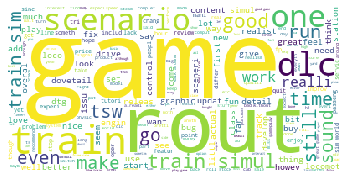

In [0]:
generate_wordcloud(pos['stemmed'])

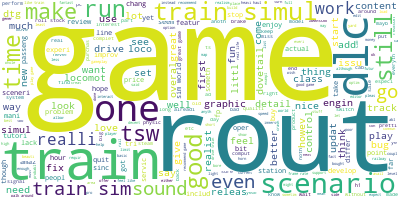

In [0]:
# Visualize the word cloud
wordcloud_pos.to_image()

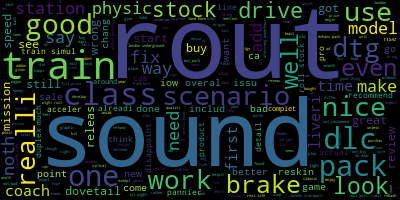

In [0]:
# Visualize the word cloud
wordcloud_neg.to_image()

## Topic Modeling

In [0]:
sns.set_style('whitegrid')
%matplotlib inline

import matplotlib.pyplot as plt
total_counts = list(np.zeros(len(words)))

for i in range(len(words)):
    for t in word_vec:
        total_counts[i]+=t[i]

In [0]:
count_dict = (zip(words, total_counts))
count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:20]

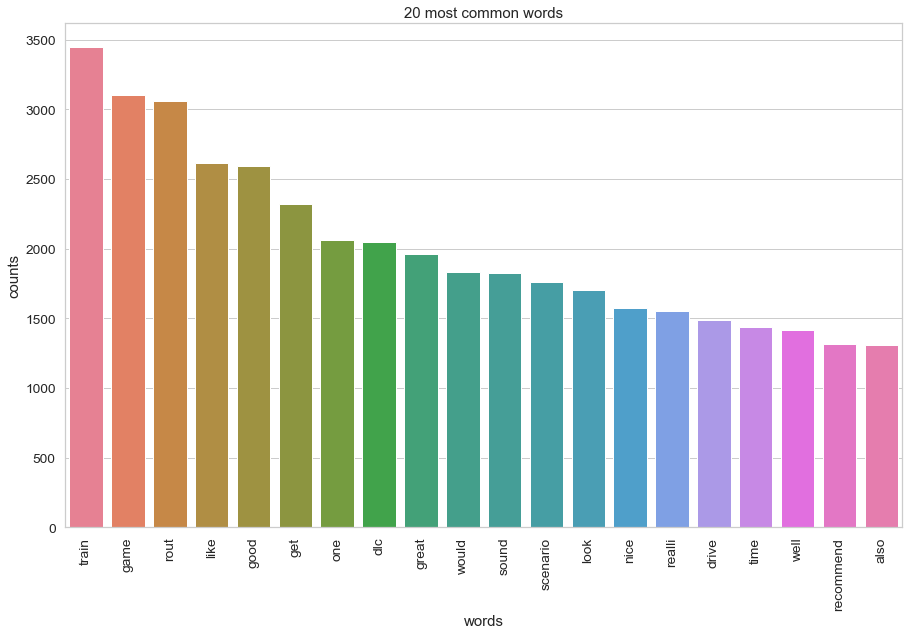

In [0]:
words = [w[0] for w in count_dict]
counts = [w[1] for w in count_dict]
x_pos = np.arange(len(words)) 
    
plt.figure(2, figsize=(15, 15/1.6180))
plt.subplot(title='20 most common words')
sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
sns.barplot(x_pos, counts, palette='husl')
plt.xticks(x_pos, words, rotation=90) 
plt.xlabel('words')
plt.ylabel('counts')
plt.show()

In [0]:
count_vectorizer = CountVectorizer()
count_data = count_vectorizer.fit_transform(data['stemmed'])
words = count_vectorizer.get_feature_names()

n_top_words = 20
n_topics = 10

model = LDA(n_topics)

id_topic = model.fit_transform(count_data)

topic_words = {}

for topic, comp in enumerate(model.components_):
    word_idx = np.argsort(comp)[::-1][:n_top_words]
    # store the words most relevant to the topic
    topic_words[topic] = [words[i] for i in word_idx]

In [0]:
for topic, words in topic_words.items():
    print('Topic: %d' % topic)
    print('  %s' % ', '.join(words))

Topic: 0
  rout, love, train, add, line, nice, 10, scenario, dlc, good, great, bad, german, light, get, signal, simul, drive, need, north
Topic: 1
  sound, good, loco, great, rout, dlc, like, nice, look, model, horn, pack, locomot, engin, recommend, class, one, would, cab, train
Topic: 2
  fish, game, like, sound, get, good, look, one, would, play, liveri, use, control, fun, cast, real, also, realli, make, go
Topic: 3
  game, train, line, get, tsw, like, one, time, money, play, dlc, content, rout, speed, signal, dtg, good, limit, drive, scenario
Topic: 4
  train, game, like, dlc, good, get, great, buy, nice, love, realli, 10, work, sim, would, play, look, one, sale, recommend
Topic: 5
  train, dlc, speed, brake, rout, get, like, drive, locomot, go, game, scenario, would, signal, loco, first, use, one, bug, see
Topic: 6
  train, rout, simul, dlc, station, game, servic, one, like, good, feel, great, detail, would, drive, passeng, new, scenario, thing, time
Topic: 7
  rout, scenario, woul

## Sentiment Analysis

In [0]:
index_list = list(range(0,len(data['Review']),1))
polarity_list = []
subjectivity_list = []

for review in data['Review']:
    article_blob = TextBlob(review)
    polarity = article_blob.sentiment.polarity
    subjectivity = article_blob.sentiment.subjectivity
    polarity_list.append(polarity)
    subjectivity_list.append(subjectivity)

In [0]:
sentiment_df = pd.DataFrame(list(zip(polarity_list,subjectivity_list)), 
               columns =['polarity', 'subjectivity'], index = index_list) 
sentiment_df.head()

,polarity,subjectivity
0,0.172184,0.417929
1,-0.117188,0.500000
2,0.170588,0.564706
3,0.163889,0.709722
4,0.259944,0.657003


In [0]:
data['polarity'] = polarity_list
data['subjectivity'] = subjectivity_list
data.head()

,GameID,SteamID,ReviewID,NumGamesOwned,NumReviewsGiven,PlayTime,PlayTimeLastTwoWeeks,LastPlayTime,Language,Review,TimeCreated,VoteUp,VoteFunny,CommentCount,SteamPurchase,WriteEarly,stemmed,word_vec,polarity,subjectivity
0,925340,76561198200016400,62850082,307,13,192,0,2/2/2020 3:00,english,Yuu is a student attending university in Tokyo...,2/2/2020 3:03,7.0,0,0,False,False,yuu student attend univers tokyo come back hom...,"[0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, ...",0.172184,0.417929
1,925340,76561198080360300,60947171,346,27,151,0,30/12/2019 14:48,english,"A short, but (bitter)sweet game. Really makes ...",30/12/2019 14:48,2.0,0,0,True,False,short bitter sweet game realli make miss late ...,"[1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, ...",-0.117188,0.500000
2,925340,76561198412449900,54724410,293,288,73,0,20/8/2019 16:12,english,Welll this VN was Something Interesting How wo...,20/8/2019 16:28,5.0,1,0,True,False,welll vn someth interest would feel belov gran...,"[0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, ...",0.170588,0.564706
3,925340,76561198130402500,54220873,322,38,162,1,21/5/2020 18:52,english,"A VN with a short, sweet story that focuses on...",21/7/2019 18:43,1.0,0,0,True,False,vn short sweet stori focus famili easi take ad...,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, ...",0.163889,0.709722
4,925340,76561198136886000,50769360,452,28,170,0,22/5/2019 11:04,english,A young man from rural Japan comes home from u...,22/5/2019 11:10,0.0,0,0,True,False,young man rural japan come home univers tokyo ...,"[0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, ...",0.259944,0.657003


In [0]:
# create labels for polarity and subjectivity
data.loc[data['polarity']<0, 'Sentiment'] = "Negative"
data.loc[data['polarity']>0, 'Sentiment'] = "Positive"
data.loc[data['polarity']==0, 'Sentiment'] = "Neutral"

data.loc[data['subjectivity']<0.5, 'Magnitude'] = "Objectve"
data.loc[data['subjectivity']>0.5, 'Magnitude'] = "Subjective"

In [0]:
data.head()

,GameID,SteamID,ReviewID,NumGamesOwned,NumReviewsGiven,PlayTime,PlayTimeLastTwoWeeks,LastPlayTime,Language,Review,TimeCreated,VoteUp,VoteFunny,CommentCount,SteamPurchase,WriteEarly,stemmed,word_vec,polarity,subjectivity,Sentiment,Magnitude
0,234190,76561198024451265,69677744,342,303,454,454,2020-05-23 10:21:53,english,"[h1]Promising, but Unfinished[/h1]\n\n+ Effect...",2020-05-23 10:28:01,NaN,0,0,True,False,h1 promis unfinish h1 effect glorifi pistol si...,"[1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",-0.032143,0.647619,Negative,Subjective
1,234190,76561197960380305,69632742,973,20,180,0,2020-04-27 17:45:26,english,"If you are reading this, you have survived the...",2020-05-22 16:22:57,0.0,0,0,True,False,read surviv mindkil,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.000000,0.000000,Neutral,Objectve
2,234190,76561198325618749,69630201,89,38,24,24,2020-05-22 15:17:47,english,the complexity of reloding the gun and such do...,2020-05-22 15:20:29,0.0,0,0,False,False,complex relod gun dosnt jive nice game tho im ...,"[1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.240000,0.757778,Positive,Subjective
3,234190,76561198177937343,69574122,101,23,689,8,2020-05-19 00:16:56,english,gun go blam\n\ni press ee1ztrT\n\ngun go blam ...,2020-05-21 17:38:36,1.0,3,0,True,False,gun go blam press ee1ztrt gun go blam,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.000000,0.000000,Neutral,Objectve
4,234190,76561198044030942,69457678,451,28,639,100,2020-05-27 15:24:22,english,"For a game made for a competition in 7 days, t...",2020-05-19 21:46:54,0.0,0,0,True,False,game made competit 7 day pretti solid tendanc ...,"[1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, ...",-0.095857,0.448368,Negative,Objectve


In [0]:
data.to_csv("/content/drive/My Drive/Steam/reviews_p1_SA.csv", index=False)

In [0]:
data.groupby('ReviewSum')['polarity'].std()

ReviewSum
Mixed              0.265942
Mostly Negative    0.202068
Mostly Positive    0.276355
Positive           0.269621
Very Positive      0.279570
Name: polarity, dtype: float64

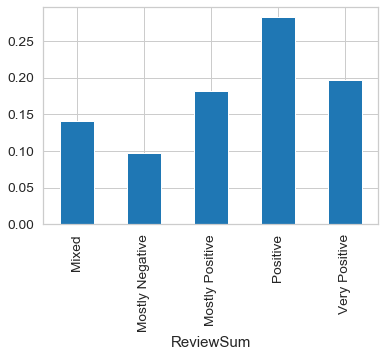

In [0]:
polarity_chart = data.groupby('ReviewSum')['polarity'].mean()
#polarity_chart.plot(kind="bar", yerr=[[0.202, 0.280], [0.280, 0.202]])
polarity_chart.plot(kind="bar")

In [0]:
data.groupby('Sentiment')['polarity'].std()

Sentiment
Negative    0.182808
Neutral     0.000000
Positive    0.208475
Name: polarity, dtype: float64

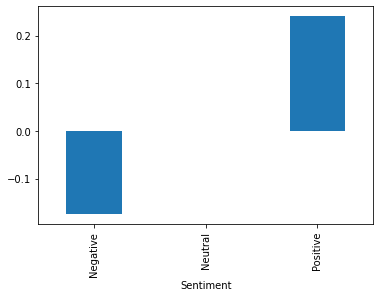

In [0]:
polarity_chart = data.groupby('Sentiment')['polarity'].mean()
#polarity_chart.plot(kind="bar", yerr=[[0.202, 0.280], [0.280, 0.202]])
polarity_chart.plot(kind="bar")

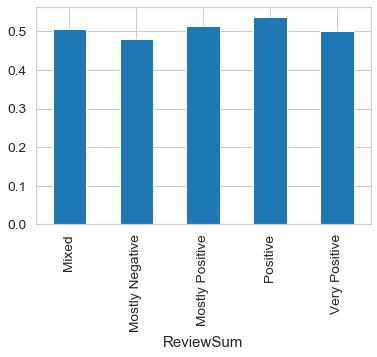

In [0]:
subjectivity_chart = data.groupby('ReviewSum')['subjectivity'].mean()
#polarity_chart.plot(kind="bar", yerr=[[0.202, 0.280], [0.280, 0.202]])
subjectivity_chart.plot(kind="bar")

## Spam Reviews EDA

### Create / Convert columns



*   NumGamesOwned: [0, 20000], mostly < 2500
*   NumReviewsGiven: [0, 5000], mostly < 250
*   PlayTime / PlayTimelastTowWeeks:  
*   VoteUp / VoteFunny / CommentCount: mostly 0
*   TimeDiff: 


In [0]:
data = pd.read_csv("/content/drive/My Drive/Steam/reviews_p2_SA.csv")

In [0]:
# Create new column 'TimeDiff'
data["TimeCreated"] = pd.to_datetime(data["TimeCreated"]).dt.date
data["LastPlayTime"] = pd.to_datetime(data["LastPlayTime"]).dt.date
data["TimeDiff"] = data['TimeCreated'] - data['LastPlayTime']
data["TimeDiff"] = data["TimeDiff"]/ np.timedelta64(1, 'D')

# convert TimeDiff to categorical variable 'TimeDiff_Cat'
data.loc[(pd.to_datetime(data["LastPlayTime"]).dt.year == 1969) | (pd.to_datetime(data["LastPlayTime"]).dt.year == 1970), 'TimeDiff_Cat'] = 'Not Played'
data.loc[data['NumGamesOwned'] == 0, 'TimeDiff_Cat'] = 'No Games' 
# 314
# len(data.loc[data['NumGamesOwned'] == 0])
# 40577
# len(data.loc[data['TimeDiff_Cat'] == 'Not Played'])
data.loc[data["TimeDiff"] > 364, 'TimeDiff_Cat'] = 'More than a year'
data.loc[(data["TimeDiff"] < 365) & (data["TimeDiff"] > 29), 'TimeDiff_Cat'] = 'More than a month'
data.loc[(data["TimeDiff"] < 30) & (data["TimeDiff"] > 9), 'TimeDiff_Cat'] = 'More than 10 days'
data.loc[(data["TimeDiff"] < 10) & (data["TimeDiff"]  > 0), 'TimeDiff_Cat'] = 'Within 10 days'
data.loc[data["TimeDiff"] == 0, 'TimeDiff_Cat'] = 'Played That Day'
data.loc[data["TimeDiff"] < 0, 'TimeDiff_Cat'] = 'Played After'

In [0]:
data['TimeDiff_Cat'].value_counts()

Played After         197446
Played That Day      113264
More than a month     48977
Not Played            25992
Within 10 days        17236
More than a year      12132
More than 10 days      7240
No Games                190
Name: TimeDiff_Cat, dtype: int64

In [0]:
print(len(data.loc[data['VoteUp'] == 0])/ 1047657)
print(len(data.loc[data['VoteFunny'] == 0])/ 1047657)
print(len(data.loc[data['CommentCount'] == 0])/ 1047657)

# convert CommentCount to categorical variable 'Comments'
data.loc[data['CommentCount'] > 9, 'Comments'] = 'Comments>10'
data.loc[(data['CommentCount'] > 0) & (data['CommentCount'] < 10), 'Comments'] = '0<Comments<10'
data.loc[data['CommentCount'] == 0, 'Comments'] = 'Comments=0'

# convert VoteFunny to categorical variable 'VF'
data.loc[data['VoteFunny'] > 14, 'VF'] = 'VoteFunny>15'
data.loc[(data['VoteFunny'] > 0) & (data['VoteFunny'] < 15), 'VF'] = '0<VoteFunny<15'
data.loc[data['VoteFunny'] == 0, 'VF'] = 'VoteFunny=0'

# convert VoteUp to categorical variable 'VU'
data.loc[data['VoteUp'] > 29, 'VU'] = 'VoteUp>30'
data.loc[(data['VoteUp'] > 0) & (data['VoteUp'] < 30), 'VU'] = '0<VoteUp<30'
data.loc[data['VoteUp'] == 0, 'VU'] = 'VoteUp=0'

0.15675454848294815
0.3254901174716534
0.3667135331506399


In [0]:
# Log NumReviewsGiven. NumGamesGiven, PlayTime
data['LogNumReviews'] = np.log(data['NumReviewsGiven'])
data.loc[data['NumGamesOwned']!=0, 'LogNumGames'] = np.log(data.loc[data['NumGamesOwned']!=0, 'NumGamesOwned'])
data.loc[data['NumGamesOwned']==0, 'LogNumGames'] = None
data.loc[data['PlayTime']!=0, 'LogPlayTime'] = np.log(data.loc[data['PlayTime']!=0, 'PlayTime'])
data.loc[data['PlayTime']==0, 'LogPlayTime'] = None

# print(len(data.loc[data['NumGamesOwned'] > 5000])/ 1047657)
# print(len(data.loc[data['NumGamesOwned'] > 2500])/ 1047657)
# print(len(data.loc[data['NumGamesOwned'] > 1400])/ 1047657)
# data.loc[data['NumGamesOwned'] > 1400, 'NumGamesOwned'] = 1400

# print()

# print(len(data.loc[data['NumReviewsGiven'] > 500])/ 1047657)
# print(len(data.loc[data['NumReviewsGiven'] > 330])/ 1047657)
# print(len(data.loc[data['NumReviewsGiven'] > 150])/ 1047657)
# data.loc[data['NumReviewsGiven'] > 150, 'NumReviewsGiven'] = 150

In [0]:
# Convert PlayTimeLastTwoWeeks to binary variable PlayLastTwoWeeks
print(len(data.loc[data['PlayTimeLastTwoWeeks'] == 0])/ 1047657)

data.loc[data['PlayTimeLastTwoWeeks'] == 0, 'PlayLastTwoWeeks'] = 0
data.loc[data['PlayTimeLastTwoWeeks'] != 0, 'PlayLastTwoWeeks'] = 1

0.39041022013884313


In [0]:
data_eda = data[['GameID', 'SteamID', 'ReviewID', 'NumGamesOwned', 'NumReviewsGiven', 'LogNumReviews', 'LogNumGames', 'LogPlayTime', 'PlayLastTwoWeeks', 'Review', 'SteamPurchase', 'WriteEarly', 'Sentiment', 'Magnitude', 'TimeDiff_Cat', 'Comments', 'VF', 'VU']]

In [0]:
data_eda.head()

,GameID,SteamID,ReviewID,NumGamesOwned,NumReviewsGiven,LogNumReviews,LogNumGames,LogPlayTime,PlayLastTwoWeeks,Review,SteamPurchase,WriteEarly,Sentiment,Magnitude,TimeDiff_Cat,Comments,VF,VU
0,925340,76561198200016400,62850082,307,13,2.564949,5.726848,5.257495,0.0,Yuu is a student attending university in Tokyo...,False,False,Positive,Objectve,Played That Day,Comments=0,VoteFunny=0,0<VoteUp<30
1,925340,76561198080360300,60947171,346,27,3.295837,5.846439,5.017280,0.0,"A short, but (bitter)sweet game. Really makes ...",True,False,Negative,NaN,Played That Day,Comments=0,VoteFunny=0,0<VoteUp<30
2,925340,76561198412449900,54724410,293,288,5.662960,5.680173,4.290459,0.0,Welll this VN was Something Interesting How wo...,True,False,Positive,Subjective,Played That Day,Comments=0,0<VoteFunny<15,0<VoteUp<30
3,925340,76561198130402500,54220873,322,38,3.637586,5.774552,5.087596,1.0,"A VN with a short, sweet story that focuses on...",True,False,Positive,Subjective,Played After,Comments=0,VoteFunny=0,0<VoteUp<30
4,925340,76561198136886000,50769360,452,28,3.332205,6.113682,5.135798,0.0,A young man from rural Japan comes home from u...,True,False,Positive,Subjective,Played That Day,Comments=0,VoteFunny=0,VoteUp=0


In [0]:
numericals = ['NumGamesOwned', 'NumReviewsGiven', 'LogNumGames', 'LogNumReviews', 'LogPlayTime']
factors = ['WriteEarly', 'SteamPurchase', 'PlayLastTwoWeeks', 'Comments', 'VF', 'VU','TimeDiff_Cat']

In [0]:
# reviews_p2_eda = pd.read_csv("/content/drive/My Drive/Steam/reviews_p2_eda.csv")
# reviews_p1_eda = pd.read_csv("/content/drive/My Drive/Steam/reviews_p1_eda.csv")
# reviews_eda_all = pd.concat([reviews_p1_eda,reviews_p2_eda])
# 1470134
#len(reviews_eda_all)

reviews_eda_all.to_csv("/content/drive/My Drive/Steam/reviews_eda_all.csv")

In [0]:
data = pd.read_csv("/content/drive/My Drive/Steam/reviews_eda_all.csv")
len(data)

1470134

### Data Process Analysis

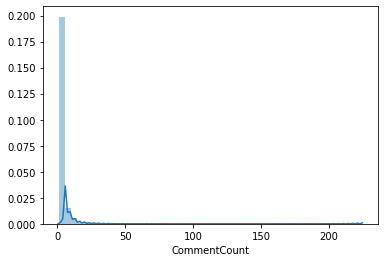

In [0]:
sns.distplot(data.loc[data['CommentCount'] != 0]['CommentCount'])

In [0]:
pd.options.display.max_rows = 1000
print(data.loc[data['CommentCount'] != 0]['CommentCount'].value_counts())

1      34595
2      15692
3       7937
4       4803
5       2862
6       1975
7       1383
8        969
9        742
10       564
11       420
12       367
13       265
14       245
15       160
16       143
17       112
18       106
19       101
20        79
21        78
22        64
24        57
25        40
29        39
27        38
26        36
23        35
28        28
31        26
30        23
33        21
32        17
39        16
34        16
37        14
46        14
49        11
42        11
36        11
40        10
35        10
38         9
43         9
48         8
69         5
65         5
50         5
52         5
67         4
59         4
58         4
57         4
76         4
55         4
62         4
51         4
70         4
45         4
41         4
82         3
66         3
64         3
44         3
53         3
47         3
78         2
60         2
56         2
54         2
94         2
63         2
81         2
92         2
220        2
93         1
115        1

In [0]:
pd.options.display.max_rows = 1000
print(data.loc[data['VoteFunny'] != 0]['VoteFunny'].value_counts())

1             95113
2             29499
3             13514
4              7382
5              4842
6              3314
7              2479
8              1829
9              1426
10             1125
11              912
12              759
13              678
14              541
15              476
16              446
20              438
19              397
17              356
18              354
21              277
22              217
23              214
25              172
24              167
27              149
26              136
29              134
28              119
32              116
33              113
31              112
30              112
34               85
38               78
37               76
36               74
39               70
35               70
40               66
41               65
43               64
47               64
45               62
42               60
46               60
48               49
44               48
50               46
49               46


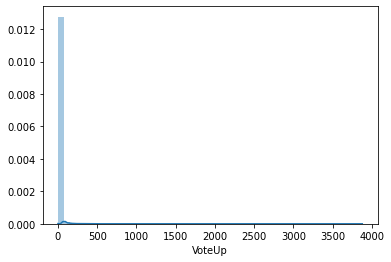

In [0]:
sns.distplot(data.loc[data['VoteUp'] != 0]['VoteUp'])

In [0]:
pd.options.display.max_rows = 1000
print(data.loc[data['VoteUp'] != 0]['VoteUp'].value_counts())

1.0       135685
2.0        63284
3.0        35443
4.0        22648
5.0        15489
6.0        11283
7.0         8739
8.0         6640
9.0         5448
10.0        4424
11.0        3577
12.0        3126
13.0        2583
14.0        2224
15.0        2044
16.0        1820
17.0        1556
18.0        1389
19.0        1276
20.0        1157
21.0        1056
22.0         970
23.0         896
24.0         782
25.0         709
27.0         681
26.0         677
28.0         591
29.0         572
31.0         524
30.0         512
32.0         457
33.0         436
34.0         431
35.0         383
36.0         375
37.0         340
38.0         317
40.0         300
39.0         291
41.0         264
42.0         243
43.0         235
45.0         233
46.0         220
50.0         219
47.0         215
44.0         202
48.0         189
49.0         176
53.0         169
52.0         168
51.0         165
54.0         157
55.0         143
56.0         130
61.0         128
57.0         124
59.0         1

In [0]:
pd.options.display.max_rows = 10000
data.loc[(pd.to_datetime(data["LastPlayTime"]).dt.year != 1969) & (pd.to_datetime(data["LastPlayTime"]).dt.year != 1970) & (data['TimeDiff'] > 0)]['TimeDiff'].value_counts()
#print(data.loc[data['TimeDiff'] > 0]['TimeDiff'].value_counts())

1.0       24849
2.0        9538
3.0        6211
4.0        4843
5.0        3877
6.0        3552
7.0        2953
8.0        2257
9.0        1944
10.0       1796
11.0       1680
12.0       1500
13.0       1475
14.0       1425
15.0       1251
16.0       1136
18.0       1060
17.0       1034
20.0       1017
19.0        984
21.0        982
22.0        902
26.0        842
24.0        799
23.0        792
25.0        775
27.0        751
28.0        748
29.0        744
30.0        614
31.0        567
33.0        538
32.0        524
34.0        514
35.0        482
37.0        469
38.0        466
39.0        454
42.0        446
40.0        441
36.0        438
46.0        435
47.0        434
49.0        429
48.0        418
41.0        403
43.0        390
51.0        384
50.0        382
44.0        382
56.0        369
45.0        365
54.0        365
53.0        352
62.0        345
52.0        342
58.0        336
55.0        332
59.0        330
63.0        326
64.0        320
65.0        318
57.0    

### Distribution Plots

In [0]:
pos = data_eda.loc[data_eda["Sentiment"] == 'Positive']
neg = data_eda.loc[data_eda["Sentiment"] == 'Negative']
obj = data_eda.loc[data_eda["Magnitude"] == 'Objective']
sub = data_eda.loc[data_eda["Magnitude"] == 'Subjective']

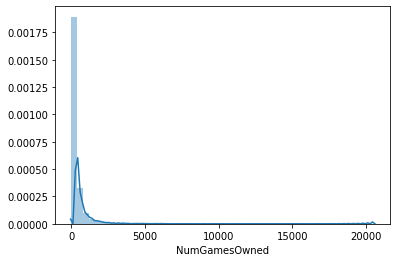

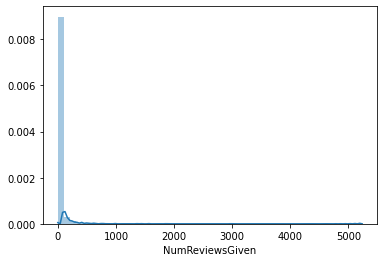

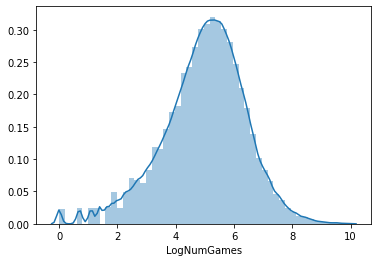

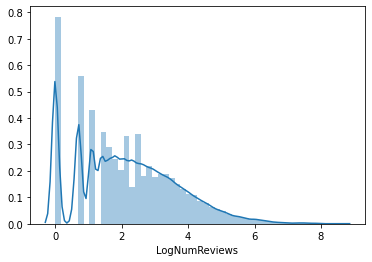

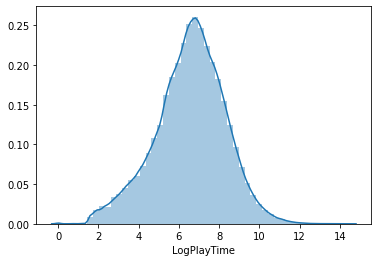

In [0]:
# Distribution Plots
i = 1
for num in numericals:
    plt.figure(i)
    #income[num].hist()
    sns.distplot(data_eda[num])
    i=i+1

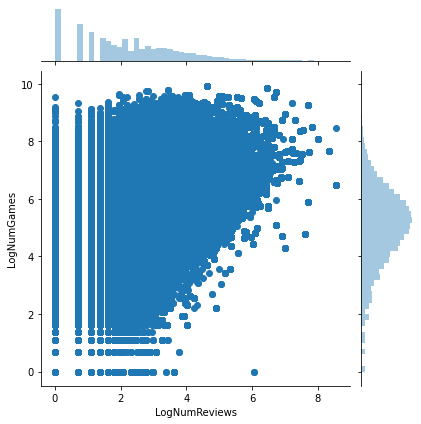

In [0]:
sns.jointplot(x=data_eda['LogNumReviews'], y=data_eda['LogNumGames'], data=data_eda);

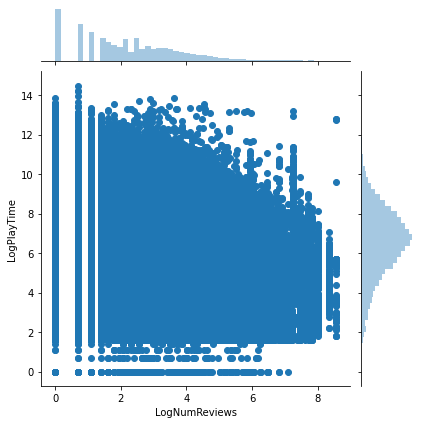

In [0]:
sns.jointplot(x=data_eda['LogNumReviews'], y=data_eda['LogPlayTime'], data=data_eda);

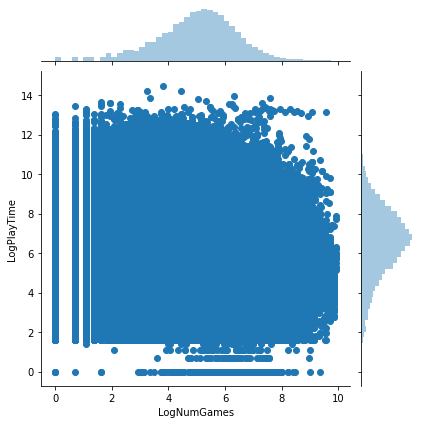

In [0]:
sns.jointplot(x=data_eda['LogNumGames'], y=data_eda['LogPlayTime'], data=data_eda);

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:198: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:198: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:198: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:198: RuntimeWarning: Mean of empt

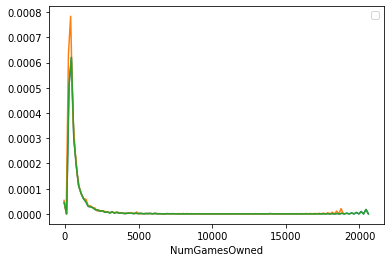

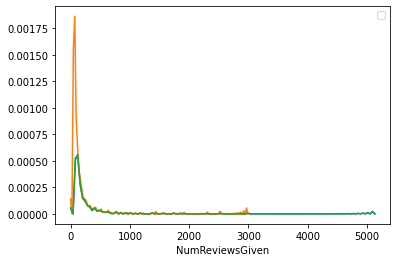

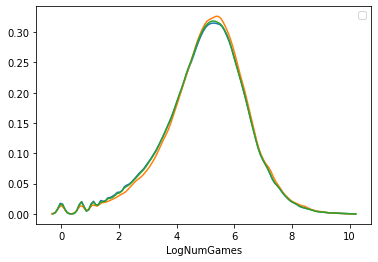

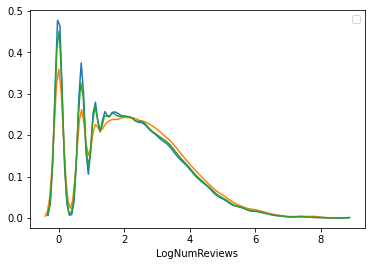

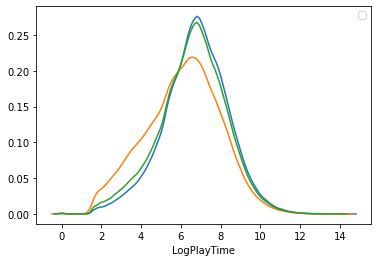

In [0]:
# Distribution Plots
i = 1
for num in numericals:
    plt.figure(i)
    #income[num].hist()
    sns.distplot(pos[num],hist=False)
    sns.distplot(neg[num],hist=False)
    sns.distplot(sub[num],hist=False)
    sns.distplot(obj[num],hist=False)
    plt.legend(['positive', 'negative', 'subjective', 'objective'])
    i=i+1

### Box Plots

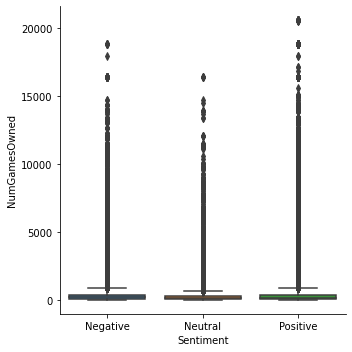

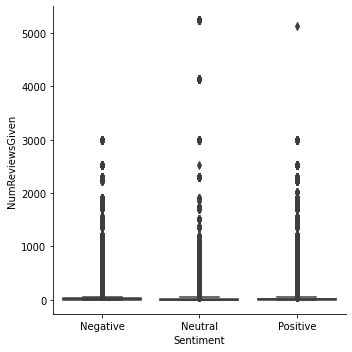

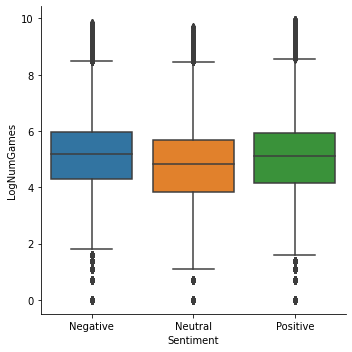

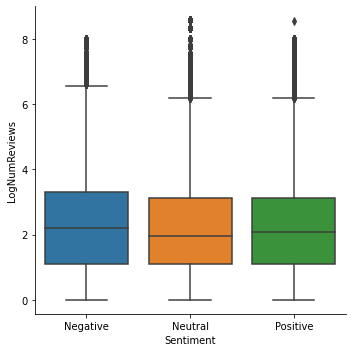

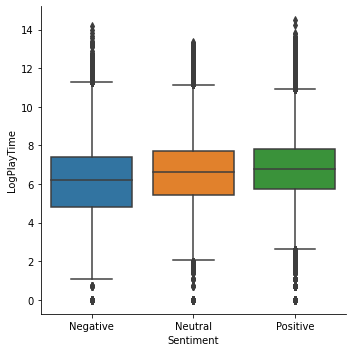

In [0]:
# box plots
for num in numericals:
    sns.catplot(x = "Sentiment", y = num, kind = "box", data = data_eda)

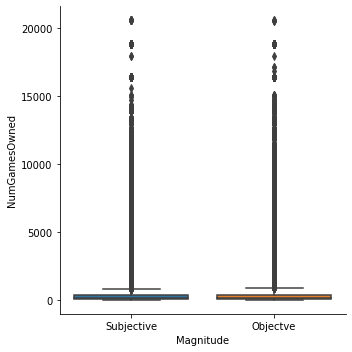

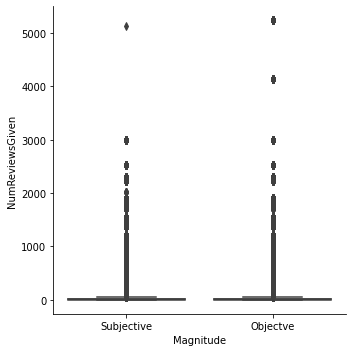

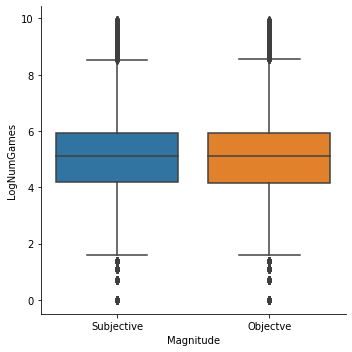

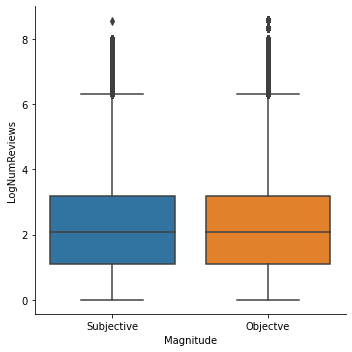

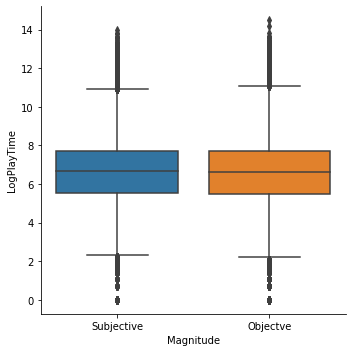

In [0]:
# box plots
for num in numericals:
    sns.catplot(x = "Magnitude", y = num, kind = "box", data = data_eda)

### Bar Charts

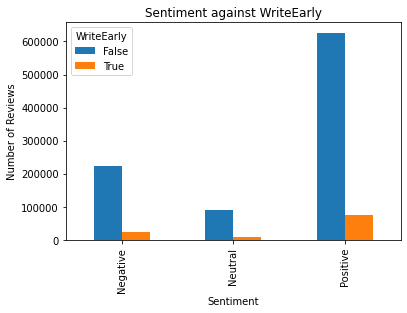

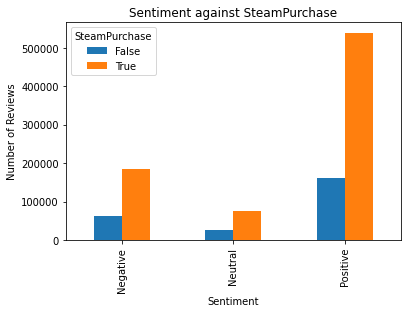

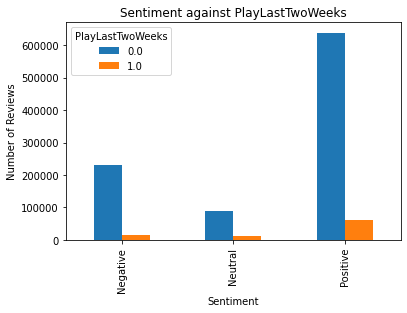

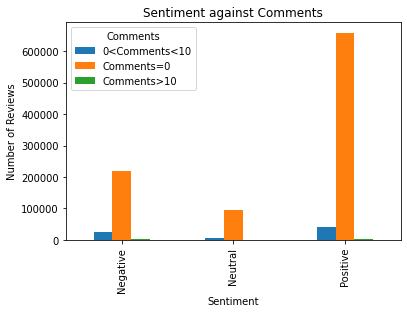

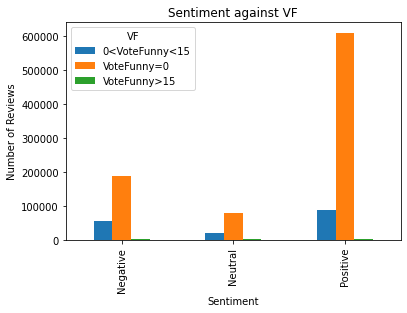

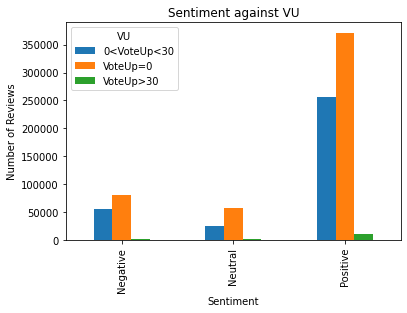

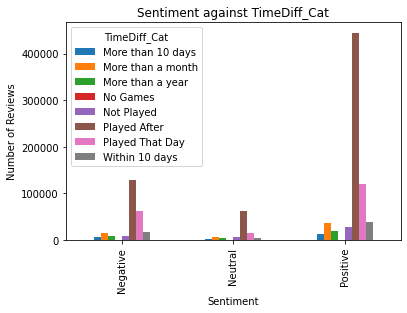

In [0]:
# bar charts
for fact in factors:
    pd.crosstab(data_eda["Sentiment"],data_eda[fact]).plot(kind='bar')
    plt.title('Sentiment against '+fact)
    plt.ylabel('Number of Reviews')

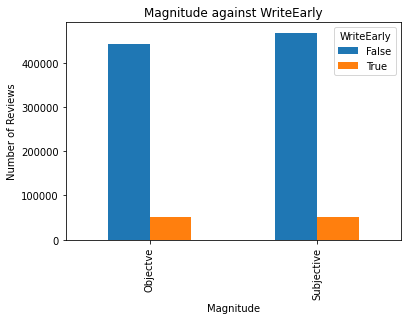

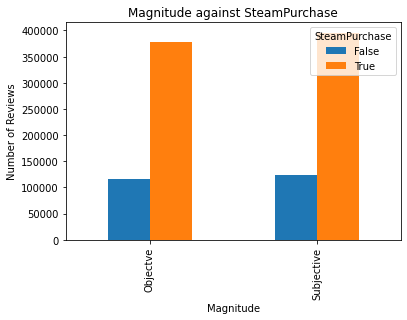

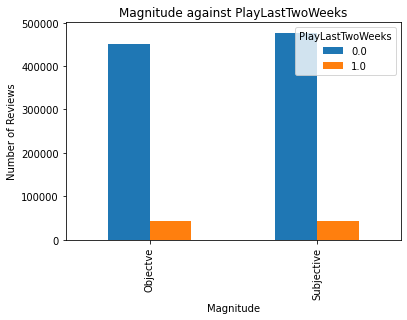

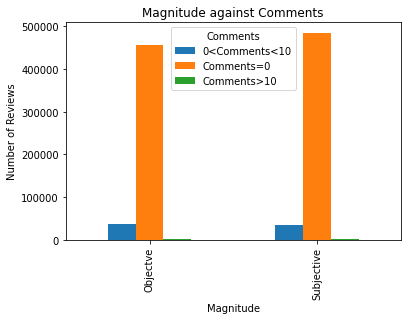

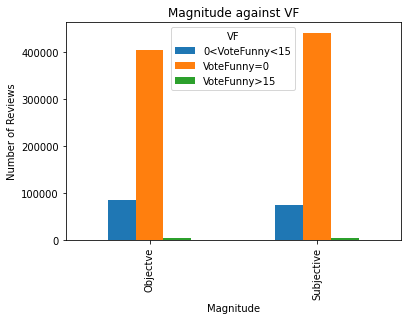

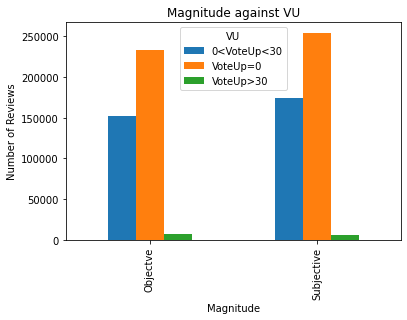

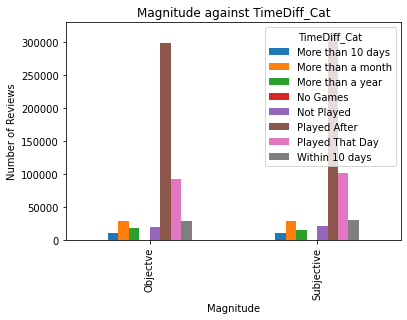

In [0]:
# bar charts
for fact in factors:
    pd.crosstab(data_eda["Magnitude"],data_eda[fact]).plot(kind='bar')
    plt.title('Magnitude against '+fact)
    plt.ylabel('Number of Reviews')

## Customer Cluster

In [0]:
data = pd.read_csv("/content/drive/My Drive/Steam/reviews_eda_all.csv")
data= data.drop(["Unnamed: 0"], axis=1)
# Recalculate log(sumPlayTime)
data['PlayTime'] = np.exp(data['LogPlayTime'])

# dropping duplicte reviewIDs 
data.sort_values("ReviewID", inplace = True) 
data.drop_duplicates(subset ="ReviewID", keep = False, inplace = True) 
data.head()

,GameID,SteamID,ReviewID,NumGamesOwned,NumReviewsGiven,LogNumReviews,LogNumGames,LogPlayTime,PlayLastTwoWeeks,Review,SteamPurchase,WriteEarly,Sentiment,Magnitude,TimeDiff_Cat,Comments,VF,VU,PlayTime
1084508,1300,76561197960267615,217,1066,83,4.418841,6.971669,NaN,0.0,SiN復活! と思いきやEpisode1の本作でスタジオ消滅。残念。,False,False,Neutral,Objectve,Not Played,Comments=0,VoteFunny=0,VoteUp=0,NaN
747283,33120,76561197960267615,232,1066,83,4.418841,6.971669,5.676754,0.0,Alien Shooter: Vengeanceを持ってたらいつの間にか2が増えていた\nな...,True,False,Negative,Subjective,Not Played,Comments=0,VoteFunny=0,VoteUp=0,292.0
915595,35130,76561197960267615,234,1066,83,4.418841,6.971669,6.107023,0.0,良作アクションなので懐事情に合わせて買うもよし、セールを待つもよし\nただしキーボードでの操...,True,False,Neutral,Objectve,Not Played,Comments=0,VoteFunny=0,VoteUp=0,449.0
735044,41500,76561197960267615,237,1066,83,4.418841,6.971669,6.899723,0.0,Diablo3出る前に2出さないといかんと思うんだけど。,False,False,Neutral,Objectve,Not Played,Comments=0,VoteFunny=0,VoteUp=0,992.0
752510,25900,76561197960267872,272,704,8,2.079442,6.556778,8.079618,0.0,You can marry a frog in this game.,True,False,Negative,Objectve,Not Played,Comments=0,VoteFunny=0,VoteUp=0,3228.0


### Identify users who game same reivews

In [0]:
# there are 108 users give more than one reviews to a same game
temp = data.groupby(['SteamID', 'GameID'])['ReviewID'].count().reset_index()
temp = temp.loc[temp['ReviewID'] != 1]
temp

,SteamID,GameID,ReviewID


In [0]:
# from the users who gave more than one reviews to a game, find out the users who gave same reviews
temp = temp.drop(['ReviewID'], axis=1)
temp_merge_data = pd.merge(temp, data, on=['SteamID','GameID'], how='left')

temp_merge_data['SimpleReview'] = temp_merge_data['Review'].str[:20]
dup_review = temp_merge_data.groupby(['SteamID','SimpleReview'])['ReviewID'].count().reset_index()
spam_users1 = dup_review.loc[dup_review['ReviewID']!=1,'SteamID'].to_list()
spam_users1 # 22 users

0      76561197960292462
5      76561197968558793
36     76561197974593679
43     76561197987804500
60     76561197993967600
71     76561198007259409
76     76561198010557138
85     76561198016635100
88     76561198021041474
95     76561198025176317
100    76561198025474673
115    76561198040781448
124    76561198045107601
125    76561198045277011
128    76561198046153044
135    76561198048475700
140    76561198058869200
157    76561198072723980
166    76561198083028788
173    76561198123783200
174    76561198128186609
177    76561198138281787
Name: SteamID, dtype: int64

In [0]:
# remove those 22 users from data
data = data.loc[~data['SteamID'].isin(spam_users1)]

In [0]:
# find out the users who gave same reviews not only to one game.
user_reviews = data.groupby(['SteamID'])['ReviewID'].count().reset_index()
user_reviews = user_reviews.loc[user_reviews['ReviewID']!=1]
user_reviews

,SteamID,ReviewID
5,76561197960267615,4
6,76561197960267872,2
7,76561197960267984,2
12,76561197960268765,2
16,76561197960269200,2
...,...,...
869601,76561199056639829,2
869688,76561199058074735,2
869761,76561199059499621,2
869777,76561199059778290,2


In [0]:
# from the users who gave more than one reviews, find out the users who gave same reviews
user_reviews = user_reviews.drop(['ReviewID'], axis=1)
user_reviews_merge_data = pd.merge(user_reviews, data, on=['SteamID'], how='left')

user_reviews_merge_data['SimpleReview'] = user_reviews_merge_data['Review'].str[:20]
dup_review2 = user_reviews_merge_data.groupby(['SteamID','SimpleReview'])['ReviewID'].count().reset_index()
spam_users2 = dup_review2.loc[dup_review2['ReviewID']!=1,'SteamID'].to_list()
len(spam_users2) # 4446 users

In [0]:
spam_users2[:10]

[76561197960271900,
 76561197960271994,
 76561197960271994,
 76561197960272100,
 76561197960272112,
 76561197960301247,
 76561197960319700,
 76561197960319700,
 76561197960319772,
 76561197960319772]

In [0]:
data.loc[data["SteamID"] == 76561197960301247]['Review'].to_list()[3]

'Not a review, just a fav'

In [0]:
# remove those 4446 users from data
data = data.loc[~data['SteamID'].isin(spam_users2)]

### Generate user dataframe

In [0]:
# save only users and his/her unique games
data = data.sort_values('SteamID').drop_duplicates(subset=['SteamID', 'GameID'])

In [0]:
# 866069 users
games_cnt = data.groupby(['SteamID'])['GameID'].count().reset_index()
games_cnt

,SteamID,GameID
0,76561197960265942,1
1,76561197960266044,1
2,76561197960266700,1
3,76561197960267039,1
4,76561197960267291,1
...,...,...
866064,76561199061043295,1
866065,76561199061163514,1
866066,76561199061175367,1
866067,76561199061314948,1


In [0]:
# aggregate games playing info on user level
gb = data.groupby(['SteamID'])[['PlayTime', 'PlayLastTwoWeeks', 'SteamPurchase']].sum().reset_index()
gb.loc[gb['PlayTime']!=0, 'LogPlayTime'] = np.log(gb.loc[gb['PlayTime']!=0, 'PlayTime'])
gb.loc[gb['PlayTime']==0, 'LogPlayTime'] = None
gb

,SteamID,PlayTime,PlayLastTwoWeeks,SteamPurchase,LogPlayTime
0,76561197960265942,63.0,0.0,1.0,4.143135
1,76561197960266044,1454.0,0.0,1.0,7.282074
2,76561197960266700,2294.0,0.0,1.0,7.738052
3,76561197960267039,40.0,1.0,0.0,3.688879
4,76561197960267291,1105.0,0.0,0.0,7.007601
...,...,...,...,...,...
866064,76561199061043295,457.0,1.0,1.0,6.124683
866065,76561199061163514,1068.0,1.0,1.0,6.973543
866066,76561199061175367,856.0,1.0,1.0,6.752270
866067,76561199061314948,886.0,1.0,1.0,6.786717


In [0]:
# merge the information into one dataframe
user_games = data[['SteamID', 'LogNumGames', 'LogNumReviews']]
user_games = user_games.sort_values('SteamID').drop_duplicates(subset=['SteamID'])

games_cnt.rename(columns={"GameID":"NumGames"})
temp = pd.merge(games_cnt, user_games, on='SteamID', how='left')

gb = gb.drop(['PlayTime'],axis=1)
temp = pd.merge(temp, gb, on='SteamID', how='left')
temp

,SteamID,NumGames,LogNumGames,LogNumReviews,PlayLastTwoWeeks,SteamPurchase,LogPlayTime
0,76561197960265942,1,7.057898,1.791759,0.0,1.0,4.143135
1,76561197960266044,1,5.991465,1.386294,0.0,1.0,7.282074
2,76561197960266700,1,6.735780,1.098612,0.0,1.0,7.738052
3,76561197960267039,1,5.099866,1.609438,1.0,0.0,3.688879
4,76561197960267291,1,5.192957,1.386294,0.0,0.0,7.007601
...,...,...,...,...,...,...,...
866064,76561199061043295,1,0.000000,0.000000,1.0,1.0,6.124683
866065,76561199061163514,1,0.693147,0.000000,1.0,1.0,6.973543
866066,76561199061175367,1,0.693147,0.000000,1.0,1.0,6.752270
866067,76561199061314948,1,0.000000,0.000000,1.0,1.0,6.786717


In [0]:
# consider NumGames in the dataset to calculate avg variables for comparision
temp['AvgPlayLastTwoWeeks'] = temp['PlayLastTwoWeeks']/temp['NumGames']
temp['AvgSteamPurchase'] = temp['SteamPurchase']/temp['NumGames']
temp['AvgLogPlayTime'] = temp['LogPlayTime']/temp['NumGames']
temp = temp.drop(['NumGames', 'PlayLastTwoWeeks', 'SteamPurchase', 'LogPlayTime'],axis=1)
users = temp
users

# the first two columns are overall summary, the last two columns are partial summary based on our dataset.

,SteamID,LogNumGames,LogNumReviews,AvgPlayLastTwoWeeks,AvgSteamPurchase,AvgLogPlayTime
0,76561197960265942,7.057898,1.791759,0.0,1.0,4.143135
1,76561197960266044,5.991465,1.386294,0.0,1.0,7.282074
2,76561197960266700,6.735780,1.098612,0.0,1.0,7.738052
3,76561197960267039,5.099866,1.609438,1.0,0.0,3.688879
4,76561197960267291,5.192957,1.386294,0.0,0.0,7.007601
...,...,...,...,...,...,...
866064,76561199061043295,0.000000,0.000000,1.0,1.0,6.124683
866065,76561199061163514,0.693147,0.000000,1.0,1.0,6.973543
866066,76561199061175367,0.693147,0.000000,1.0,1.0,6.752270
866067,76561199061314948,0.000000,0.000000,1.0,1.0,6.786717


### Customer Segmentation

In [0]:
numericals = users.columns.to_list()

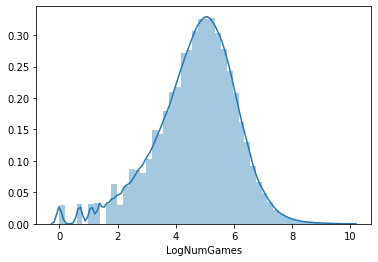

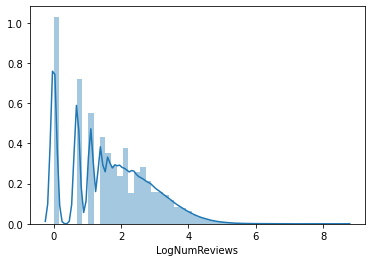

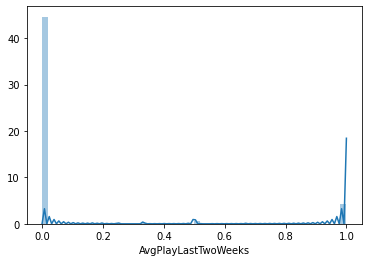

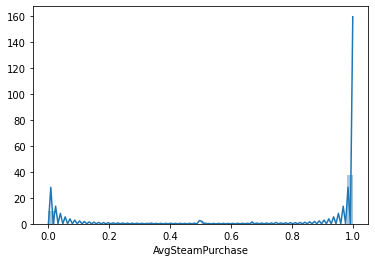

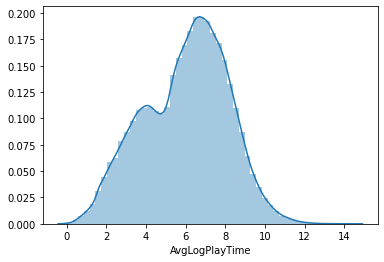

In [0]:
# Distribution Plots
i = 1
for num in numericals[1:]:
    plt.figure(i)
    #income[num].hist()
    sns.distplot(users[num])
    i=i+1

Play much: AvgLogPlayTime [ , 3], [3,6], [6, 8.5], [8.5, ]  
Buy much: LogNumGames [ ,2], [2,4], [4,6], [6, ]   
Active: AvgPlayLastTwoWeeks 0/1 

Play much and buy much are the two most important factors. Based on the two, we can derive a quadrant.

1. play much & buy much (game fans; game lovers): focus on both active (profitable) and inactive (easy to retain) users.
2. play much & buy not much (game devoters): focus on inactive users considering they're very likely to start playing the old game again considering addiction. Recommendations should be very nache.
3. play not much & buy much (game collectors): grab the recent playing users, namely focusing on active users to make them play more or buy more. Recommendations can be broadly associated. 
3. play not much & buy not much (random gamers): not much value

In [0]:
# segment one: game fans (they play very much and they are game collectors)
# this is the segment that can closely study and customize recommendations
# LogNumGames > 6; AvgLogPlayTime > 8.5
seg_one = users.loc[(users['LogNumGames'] > 6) & (users['AvgLogPlayTime'] > 8.5)]
print(len(seg_one))
print(len(seg_one)/len(users))

# retain inactive users in seg_one is the easiest
seg_one_inactive = seg_one.loc[seg_one['AvgPlayLastTwoWeeks'] == 0]
print(len(seg_one_inactive))
print(len(seg_one_inactive)/len(seg_one))

# active users in seg_one are most profitable
seg_one_active = seg_one.loc[seg_one['AvgPlayLastTwoWeeks'] != 0]
print(len(seg_one_active))
print(len(seg_one_active)/len(seg_one))

6010
0.006939400902237582
5045
0.8394342762063228
965
0.1605657237936772


In [0]:
# segment two: game lovers (they play much and they not play only a few games)
# LogNumGames >4; AvgLogPlayTime > 6
seg_two = users.loc[(users['LogNumGames'] > 4) & (users['AvgLogPlayTime'] > 6)]
seg_two = seg_two.loc[~seg_two['SteamID'].isin(seg_one['SteamID'].to_list())]
print(len(seg_two))
print(len(seg_two)/len(users))

seg_two_inactive = seg_two.loc[seg_two['AvgPlayLastTwoWeeks'] == 0]
print(len(seg_two_inactive))
print(len(seg_two_inactive)/len(seg_two))

295250
0.3409081724435351
265891
0.9005622353937341


In [0]:
# segment three: game devoters (they play very much but only focused on a few games)
# LogNumGames < 2; AvgLogPlayTime < 8.5
seg_three = users.loc[(users['LogNumGames'] < 2) & (users['AvgLogPlayTime'] > 8.5)]
print(len(seg_three))
print(len(seg_three)/len(users))

# considering the proportion is not that large, we think those game devoters play routinely.
# Thus, it's more easy to retain these inactive gamers.
# But the latent profits may not be much, considering they may not willing to try new games.
seg_three_inactive = seg_three.loc[seg_three['AvgPlayLastTwoWeeks'] == 0]
print(len(seg_three_inactive))
print(len(seg_three_inactive)/len(seg_three))

seg_three_inactive['SteamID'].to_list()
# game level merge
# user - game - genre- gamename
# groupby genre 
# groupby genre find out top games in that genre
# who doesn't play top games

8656
0.009994584727082947
4402
0.5085489833641405


In [0]:
# segment four: game collectors (they buy much but not play much)
# LogNumGames > 6; AvgLogPlayTime < 3
seg_four = users.loc[(users['LogNumGames'] > 6) & (users['AvgLogPlayTime'] < 3)]
print(len(seg_four))
print(len(seg_four)/len(users))

seg_four_inactive = seg_four.loc[seg_four['AvgPlayLastTwoWeeks'] == 0]
print(len(seg_four_inactive))
print(len(seg_four_inactive)/len(seg_four))

# we should focus more on those active users. They don't play much often but recently they are playing.
# we need to grab the opportunities to make they play more or buy more.
seg_four_active = seg_four.loc[seg_four['AvgPlayLastTwoWeeks'] != 0]
print(len(seg_four_active))
print(len(seg_four_active)/len(seg_four))

# target activer users
# association rules mining 
# user - genre


29701
0.03429403430904466
27212
0.916198107807818
2489
0.08380189219218208


### K-Means

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn.cluster import KMeans

In [0]:
users_cleand = users.loc[~np.isnan(users['LogNumGames'])]
users_cleand = users_cleand.loc[~users['AvgPlayLastTwoWeeks'].isna()]
users_cleand = users_cleand.loc[~users['AvgLogPlayTime'].isna()]
users_cleand = users_cleand.loc[~np.isnan(users['AvgPlayLastTwoWeeks'])]
users_cleand = users_cleand.loc[~np.isnan(users['AvgLogPlayTime'])]

In [0]:
kmeans = KMeans(n_clusters=4)
y = kmeans.fit_predict(users_cleand[['LogNumGames', 'AvgLogPlayTime']])
users_cleand['Cluster'] = y

kmeans = KMeans(n_clusters=5)
y = kmeans.fit_predict(users_cleand[['LogNumGames', 'AvgLogPlayTime']])
users_cleand['Cluster_5'] = y

In [0]:
users_cleand.groupby('Cluster')['LogNumGames', 'AvgPlayLastTwoWeeks', 'AvgLogPlayTime'].mean().reset_index()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,Cluster,LogNumGames,AvgPlayLastTwoWeeks,AvgLogPlayTime
0,0,5.299297,0.037200,3.223203
1,1,4.570037,0.191747,8.504952
2,2,5.320633,0.045630,6.115321
3,3,2.672412,0.170618,6.725275


In [0]:
users_cleand.groupby('Cluster_5')['LogNumGames', 'AvgPlayLastTwoWeeks', 'AvgLogPlayTime'].mean().reset_index()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,Cluster_5,LogNumGames,AvgPlayLastTwoWeeks,AvgLogPlayTime
0,0,5.396416,0.046676,6.249074
1,1,5.760886,0.030216,3.006109
2,2,2.641156,0.230283,7.616862
3,3,4.863977,0.169857,8.451684
4,4,3.807605,0.061368,4.584773


n=4:  
1. Cluster 0 : Game collectors
2. Cluster 1: Game fans
3. Cluster 2: Game lovers
4. Cluster 3: Game devoters

n=5:  
1. Cluster 0 : Game lovers
2. Cluster 1: Game collectors
3. Cluster 2: Game devoters
4. Cluster 3: Game fans
5. Cluster 4: Random gamers

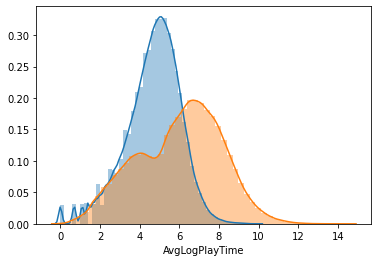

In [0]:
sns.distplot(users['LogNumGames'])
sns.distplot(users['AvgLogPlayTime'])